##Carga de los datos: 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import os
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
import warnings 
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np 
import os
import re 

import nltk
nltk.download("all")
import matplotlib.pyplot as plt
import torch
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
stopSpanish=set(stopwords.words('spanish'))


##################################### Formato
import pandas as pd
import numpy as np
###################################### Procesamiento de texto
import nltk
#Descarga toda la informacion de los lenguajes que se consideren
nltk.download("all")
import matplotlib.pyplot as plt
from tqdm import tqdm
################################## Funciones de utilidades para construccion de conjuntos necesarios para entrenamiento
import torch
!pip install datasets
import datasets

from datasets import Dataset
import torch.nn as nn
import torch.optim as optim
import math
import torchtext
from torch.utils.data import DataLoader
from torchtext.data import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import re
import os

import pandas as pd
url='https://drive.google.com/file/d/1i-6kb6y9gETt6rZ_9XapZOY9RV5KXSLj/view?usp=sharing'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
train = pd.read_csv(url).drop(columns=['Unnamed: 0', 'Longitud', 'Unnamed: 0.1'])


url1='https://drive.google.com/file/d/1-18w1iuu41336O5dL1NaBnL0rR4jMreZ/view?usp=sharing'
url1='https://drive.google.com/uc?id=' + url1.split('/')[-2]
test= pd.read_csv(url1).drop(columns=['Unnamed: 0'])

#train=pd.read_csv('/content/drive/MyDrive/Tweets_Emilio/Entrenamiento/train_final.csv').drop(columns=['Unnamed: 0', 'Longitud', 'Unnamed: 0.1'])
#test=pd.read_csv('/content/drive/MyDrive/Tweets_Emilio/Prueba/test_final.csv').drop(columns=['Unnamed: 0'])

train = train.replace(to_replace='None', value=np.nan).dropna().reset_index()
test = test.replace(to_replace='None', value=np.nan).dropna().reset_index()

dataframes = {
  'train': train, 
  'test': test
}

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    |   Package bcp47 is already up-to-dat

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#c) Clasificador basado en redes convolucionales

Funcion que se encarga de obtener todos los tokens considerados para el vocabulario, para luego generar representaciones tokenizadas de la misma longitud, si es mas larga pues la corta y si es mas corta llena los espacios con tokens de padding

In [ ]:
from collections import defaultdict

def tokenize(texts):
    """Tokenize texts, build vocabulary and find maximum sentence length.
    
    Args:
        texts (List[str]): List of text data
    
    Returns:
        tokenized_texts (List[List[str]]): List of list of tokens
        word2idx (Dict): Vocabulary built from the corpus
        max_len (int): Maximum sentence length
    """

    max_len = 0
    tokenized_texts = []
    word2idx = {}

    # Add <pad> and <unk> tokens to the vocabulary
    word2idx['<pad>'] = 0
    word2idx['<unk>'] = 1

    # Building our vocab from the corpus starting from index 2
    idx = 2
    for sent in texts:
        tokenized_sent = word_tokenize(sent)
        #Quitamos las stop words del idioma
        #tokenized_sent=[word for word in tokenized_sent if not word in stopSpanish]
        #Quitamos los signos de puntuacion
        #tokenized_sent = [word.lower() for word in tokenized_sent if word.isalpha()]
        # Add `tokenized_sent` to `tokenized_texts` pero ya preprocesado 
        tokenized_texts.append(tokenized_sent)

        # Add new token to `word2idx`
        for token in tokenized_sent:
            if token not in word2idx:
                word2idx[token] = idx
                idx += 1

        # Update `max_len`
        max_len = max(max_len, len(tokenized_sent))

    return tokenized_texts, word2idx, max_len

def encode(tokenized_texts, word2idx, max_len):
    """Pad each sentence to the maximum sentence length and encode tokens to
    their index in the vocabulary.

    Returns:
        input_ids (np.array): Array of token indexes in the vocabulary with
            shape (N, max_len). It will the input of our CNN model.
    """

    input_ids = []
    for tokenized_sent in tokenized_texts:
        # Pad sentences to max_len
        tokenized_sent += ['<pad>'] * (max_len - len(tokenized_sent))

        # Encode tokens to input_ids
        input_id = [word2idx.get(token) for token in tokenized_sent]
        input_ids.append(input_id)
    
    return np.array(input_ids)

from tqdm import tqdm_notebook

def load_pretrained_vectors(word2idx, fname):
    """Load pretrained vectors and create embedding layers.
    
    Args:
        word2idx (Dict): Vocabulary built from the corpus
        fname (str): Path to pretrained vector file

    Returns:
        embeddings (np.array): Embedding matrix with shape (N, d) where N is
            the size of word2idx and d is embedding dimension
    """

    print("Loading pretrained vectors...")
    fin = open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())

    # Initilize random embeddings
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), d))
    embeddings[word2idx['<pad>']] = np.zeros((d,))

    # Load pretrained vectors
    count = 0
    for line in tqdm_notebook(fin):
        tokens = line.rstrip().split(' ')
        word = tokens[0]
        if word in word2idx:
            count += 1
            embeddings[word2idx[word]] = np.array(tokens[1:], dtype=np.float32)

    print(f"There are {count} / {len(word2idx)} pretrained vectors found.")

    return embeddings

Esta funcion nos permite cargar vectores pre-entrenados en caso de buscar enriquecer los resultados mediante transfer learning.

In [ ]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla V100-SXM2-16GB


Utilizamos las funciones de antes para obtener un vocabulario y las representaciones tokenizadas

Construccion de los data loaders

In [ ]:
from torch.utils.data import (TensorDataset, DataLoader, RandomSampler,
                              SequentialSampler)

def data_loader(train_inputs, val_inputs, train_labels, val_labels, batch_size=32):
    """Convert train and validation sets to torch.Tensors and load them to
    DataLoader.
    """

    # Convert data type to torch.Tensor
    train_inputs, val_inputs, train_labels, val_labels =tuple(torch.tensor(data) for data in [train_inputs, val_inputs, train_labels, val_labels])

    # Specify batch_size
    batch_size = batch_size#era 50

    # Create DataLoader for training data
    train_data = TensorDataset(train_inputs, train_labels)
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

    # Create DataLoader for validation data
    val_data = TensorDataset(val_inputs, val_labels)
    val_sampler = SequentialSampler(val_data)
    val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

    return train_dataloader, val_dataloader


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN_NLP(nn.Module):
    """An 1D Convulational Neural Network for Sentence Classification."""
    def __init__(self,
                 pretrained_embedding=None,
                 freeze_embedding=False,
                 vocab_size=None,
                 embed_dim=300,
                 filter_sizes=[3, 4, 5],
                 num_filters=[100, 100, 100],
                 num_classes=4,
                 dropout=0.5):
        """
        The constructor for CNN_NLP class.

        Args:
            pretrained_embedding (torch.Tensor): Pretrained embeddings with
                shape (vocab_size, embed_dim)
            freeze_embedding (bool): Set to False to fine-tune pretraiend
                vectors. Default: False
            vocab_size (int): Need to be specified when not pretrained word
                embeddings are not used.
            embed_dim (int): Dimension of word vectors. Need to be specified
                when pretrained word embeddings are not used. Default: 300
            filter_sizes (List[int]): List of filter sizes. Default: [3, 4, 5]
            num_filters (List[int]): List of number of filters, has the same
                length as `filter_sizes`. Default: [100, 100, 100]
            n_classes (int): Number of classes. Default: 2
            dropout (float): Dropout rate. Default: 0.5
        """

        super(CNN_NLP, self).__init__()
        # Embedding layer
        if pretrained_embedding is not None:
            self.vocab_size, self.embed_dim = pretrained_embedding.shape
            self.embedding = nn.Embedding.from_pretrained(pretrained_embedding,
                                                          freeze=freeze_embedding)
        else:
            self.embed_dim = embed_dim
            self.embedding = nn.Embedding(num_embeddings=vocab_size,
                                          embedding_dim=self.embed_dim,
                                          padding_idx=0,
                                          max_norm=5.0)
        # Conv Network
        self.conv1d_list = nn.ModuleList([
            nn.Conv1d(in_channels=self.embed_dim,
                      out_channels=num_filters[i],
                      kernel_size=filter_sizes[i])
            for i in range(len(filter_sizes))
        ])
        self.num_classes=num_classes
        # Fully-connected layer and Dropout
        self.fc = nn.Linear(np.sum(num_filters), num_classes)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, input_ids):
        """Perform a forward pass through the network.

        Args:
            input_ids (torch.Tensor): A tensor of token ids with shape
                (batch_size, max_sent_length)

        Returns:
            logits (torch.Tensor): Output logits with shape (batch_size,
                n_classes)
        """

        # Get embeddings from `input_ids`. Output shape: (b, max_len, embed_dim)
        x_embed = self.embedding(input_ids).float()

        # Permute `x_embed` to match input shape requirement of `nn.Conv1d`.
        # Output shape: (b, embed_dim, max_len)
        x_reshaped = x_embed.permute(0, 2, 1)

        # Apply CNN and ReLU. Output shape: (b, num_filters[i], L_out)
        x_conv_list = [F.relu(conv1d(x_reshaped)) for conv1d in self.conv1d_list]

        # Max pooling. Output shape: (b, num_filters[i], 1)
        x_pool_list = [F.max_pool1d(x_conv, kernel_size=x_conv.shape[2])
            for x_conv in x_conv_list]
        
        # Concatenate x_pool_list to feed the fully connected layer.
        # Output shape: (b, sum(num_filters))
        x_fc = torch.cat([x_pool.squeeze(dim=2) for x_pool in x_pool_list],
                         dim=1)
        
        # Compute logits. Output shape: (b, n_classes)
        logits = self.fc(self.dropout(x_fc))

        return logits
        
import torch.optim as optim

def initilize_model(pretrained_embedding=None,
                    freeze_embedding=False,
                    vocab_size=None,
                    embed_dim=300,
                    filter_sizes=[3, 4, 5],
                    num_filters=[100, 100, 100],
                    num_classes=4,
                    dropout=0.5,
                    learning_rate=0.01):
    """Instantiate a CNN model and an optimizer."""
    #self.num_classes=num_classes
    assert (len(filter_sizes) == len(num_filters)), "filter_sizes and \
    num_filters need to be of the same length."

    # Instantiate CNN model
    cnn_model = CNN_NLP(pretrained_embedding=pretrained_embedding,
                        freeze_embedding=freeze_embedding,
                        vocab_size=vocab_size,
                        embed_dim=embed_dim,
                        filter_sizes=filter_sizes,
                        num_filters=num_filters,
                        num_classes=num_classes,
                        dropout=0.5)
    
    # Send model to `device` (GPU/CPU)
    cnn_model.to(device)

    # Instantiate Adadelta optimizer
    optimizer = optim.Adadelta(cnn_model.parameters(),
                               lr=learning_rate,
                               rho=0.95)

    return cnn_model, optimizer
    
import random
import time

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility."""

    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, optimizer, train_dataloader, val_dataloader=None, epochs=20):
    """Train the CNN model."""
    
    # Tracking best validation accuracy
    best_accuracy = 0

    # Start training loop
    print("Start training...\n")
    print(f"{'Epoch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
    print("-"*60)

    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================

        # Tracking time and loss
        t0_epoch = time.time()
        total_loss = 0

        # Put the model into the training mode
        model.train()

        for step, batch in enumerate(train_dataloader):
            # Load batch to GPU
            b_input_ids, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Update parameters
            optimizer.step()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        # =======================================
        #               Evaluation
        # =======================================
        if val_dataloader is not None:
            # After the completion of each training epoch, measure the model's
            # performance on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Track the best accuracy
            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            print(f"{epoch_i + 1:^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            
    print("\n")
    print(f"Training complete! Best accuracy: {best_accuracy:.2f}%.")

def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's
    performance on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled
    # during the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [ ]:
#La funcion se modificó para que funcione con nuestro numero de clases y que preprocese los datos si es necesario

def predict(test, model, max_len=100):
  """Predict probability that a review is positive."""
  model.to("cpu")
  asign=torch.zeros(len(test))

  for i in range(len(test)):
    # Tokenize, pad and encode text
    tokenized_sent = word_tokenize(test[i].lower())
    #Quitamos las stop words del idioma
    #tokenized_sent=[word for word in tokenized_sent if not word in stopSpanish]
    #Quitamos los signos de puntuacion
    #tokenized_sent = [word.lower() for word in tokenized_sent if word.isalpha()]
    padded_tokens = tokenized_sent + ['<pad>'] * (max_len - len(tokenized_sent))
    #Vemos si esta o no en el vocabulario
    input_id = [word2idx.get(token, word2idx['<unk>']) for token in padded_tokens]
    # Convert to PyTorch tensors
    input_id = torch.tensor(input_id).unsqueeze(dim=0)
    # Compute logits
    logits = model.forward(input_id)
    #  Compute probability
    probs = F.softmax(logits, dim=1).squeeze(dim=0)
    asign[i]=torch.argmax(probs)
  return(asign)

##Entrenamiento de Clasificador

Recordando un poco, nosotros ya teniamos un modelo de la tarea pasada, asi que esta vez solo seleccione los parametros necesarios para hacer este entrenamiento y poder guardarlo correctamente

### Original

In [ ]:
texts=list(dataframes['train']['tweet'])+list(dataframes['test']['tweet'])
# Tokenize, build vocabulary, encode tokens
print("Tokenizing...\n")
tokenized_texts, word2idx, max_len = tokenize(texts)
input_ids = encode(tokenized_texts, word2idx, max_len)
#Longitud del vocabulario
print(len(word2idx))

import torch 
# Load pretrained vectors
embeddings = load_pretrained_vectors(word2idx, '/content/drive/MyDrive/embeddings-l-model.vec')
print(embeddings.shape)

embeddings = torch.tensor(embeddings)
embeddings = embeddings.to(device)

Tokenizing...

80431
Loading pretrained vectors...


0it [00:00, ?it/s]

There are 42860 / 80431 pretrained vectors found.
(80431, 300)


In [ ]:
from sklearn.model_selection import train_test_split

labels=np.array(dataframes['train']['ideology_binary'].map({'left': 0,  'right': 1}))
#labels1=np.array(test['ideology_binary'].map({'left': 0, 'right': 1}))
#labels=np.array(train['ideology_multiclass'].map({'left': 0, 'moderate_left':1, 'moderate_right': 2, 'right': 3}))

# Train Test Split
train_inputs, val_inputs, train_labels, val_labels = train_test_split(input_ids[0:42558, ], labels[0:42558], test_size=0.1, random_state=2023)
# Load data to PyTorch DataLoader
train_dataloader, val_dataloader = data_loader(train_inputs, val_inputs, train_labels, val_labels, batch_size=16)

####Binario

In [ ]:
set_seed(2022)
cnn_rand3, optimizer = initilize_model(vocab_size=len(word2idx),
                                      embed_dim=600,freeze_embedding=True,
                                      learning_rate=0.25,
                                      dropout=0.5)
train(cnn_rand3, optimizer, train_dataloader, val_dataloader, epochs=20)

Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |   0.645706   |  0.593906  |   67.13   |   77.42  
   2    |   0.569524   |  0.536975  |   73.03   |   70.62  
   3    |   0.480821   |  0.501221  |   75.52   |   70.16  
   4    |   0.369475   |  0.492964  |   76.83   |   70.21  
   5    |   0.264768   |  0.495379  |   77.61   |   70.11  
   6    |   0.183936   |  0.531111  |   77.87   |   70.04  
   7    |   0.134183   |  0.581403  |   78.59   |   70.15  
   8    |   0.105737   |  0.627741  |   78.48   |   70.15  
   9    |   0.084135   |  0.656904  |   79.16   |   69.96  
  10    |   0.065898   |  0.690186  |   78.69   |   70.05  
  11    |   0.057412   |  0.731675  |   78.69   |   70.04  
  12    |   0.044069   |  0.750813  |   79.11   |   70.12  
  13    |   0.042621   |  0.786287  |   78.48   |   70.05  
  14    |   0.034824   |  0.832171  |   79.21   |   70.03  
  15    |   0.033704

In [ ]:
"""Predict probability that a review is positive."""
labels1=np.array(dataframes['test']['ideology_binary'].map({'left': 0,  'right': 1}))
candidato1=predict(list(test['tweet']), model=cnn_rand3)
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
#yhat_CONV=candidato1

#Algunas metricas medias
print('Accuracy', accuracy_score(labels1,candidato1))
print('F1-Score', np.mean(f1_score(labels1, candidato1, average='macro')))

print("\nConfusion Matrix : ")
print(confusion_matrix(labels1, candidato1))

Accuracy 0.879
F1-Score 0.8560892674705844

Confusion Matrix : 
[[240  10]
 [111 639]]


In [ ]:
set_seed(2022)
cnn_rand3, optimizer = initilize_model(vocab_size=len(word2idx),
                                      embed_dim=600,freeze_embedding=True,
                                      learning_rate=0.25,
                                      dropout=0.5, num_classes=2)
train(cnn_rand3, optimizer, train_dataloader, val_dataloader, epochs=20)

Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |   0.646504   |  0.599031  |   66.56   |   70.01  
   2    |   0.572389   |  0.542322  |   72.49   |   69.85  
   3    |   0.484714   |  0.501291  |   75.38   |   69.80  
   4    |   0.369170   |  0.485231  |   77.33   |   69.78  
   5    |   0.265217   |  0.492416  |   78.45   |   70.11  
   6    |   0.186427   |  0.527494  |   78.05   |   70.24  
   7    |   0.136358   |  0.576515  |   78.20   |   70.24  
   8    |   0.107321   |  0.617948  |   79.32   |   70.48  
   9    |   0.085674   |  0.643940  |   79.09   |   70.24  
  10    |   0.064976   |  0.692511  |   78.95   |   70.25  
  11    |   0.056174   |  0.702298  |   78.71   |   70.13  
  12    |   0.048197   |  0.755661  |   78.74   |   69.70  
  13    |   0.039084   |  0.843148  |   78.67   |   69.77  
  14    |   0.036957   |  0.834696  |   79.06   |   69.76  
  15    |   0.032137

In [ ]:
"""Predict probability that a review is positive."""
labels1=np.array(dataframes['test']['ideology_binary'].map({'left': 0,  'right': 1}))
candidato1=predict(list(test['tweet']), model=cnn_rand3)
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
#yhat_CONV=candidato1

#Algunas metricas medias
print('Accuracy', accuracy_score(labels1,candidato1))
print('F1-Score', np.mean(f1_score(labels1, candidato1, average='macro')))

print("\nConfusion Matrix : ")
print(confusion_matrix(labels1, candidato1))

Accuracy 0.908
F1-Score 0.8871304134462029

Confusion Matrix : 
[[239  11]
 [ 81 669]]


In [ ]:
set_seed(2022)
cnn_rand3, optimizer = initilize_model(vocab_size=len(word2idx),
                                       pretrained_embedding=embeddings,#freeze_embedding=True,
                                      learning_rate=0.25,
                                      dropout=0.5, num_classes=2)
train(cnn_rand3, optimizer, train_dataloader, val_dataloader, epochs=20)

Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |   0.621874   |  0.557275  |   70.82   |   73.69  
   2    |   0.528578   |  0.504631  |   74.58   |   73.59  
   3    |   0.448010   |  0.485064  |   76.50   |   73.52  
   4    |   0.364327   |  0.474719  |   78.41   |   73.90  
   5    |   0.288078   |  0.460882  |   79.37   |   74.08  
   6    |   0.222610   |  0.516239  |   79.02   |   73.99  
   7    |   0.172788   |  0.515922  |   80.24   |   73.67  
   8    |   0.136549   |  0.543944  |   80.80   |   73.71  
   9    |   0.104728   |  0.580134  |   80.55   |   73.68  
  10    |   0.088444   |  0.617323  |   80.87   |   73.81  
  11    |   0.074660   |  0.633132  |   80.66   |   73.72  
  12    |   0.061687   |  0.679645  |   80.97   |   73.48  
  13    |   0.051631   |  0.709525  |   81.09   |   73.52  
  14    |   0.047756   |  0.773054  |   80.76   |   73.47  
  15    |   0.042903

In [ ]:
"""Predict probability that a review is positive."""
labels1=np.array(dataframes['test']['ideology_binary'].map({'left': 0,  'right': 1}))
candidato1=predict(list(test['tweet']), model=cnn_rand3)
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
#yhat_CONV=candidato1

#Algunas metricas medias
print('Accuracy', accuracy_score(labels1,candidato1))
print('F1-Score', np.mean(f1_score(labels1, candidato1, average='macro')))

print("\nConfusion Matrix : ")
print(confusion_matrix(labels1, candidato1))

Accuracy 0.852
F1-Score 0.8285250839995366

Confusion Matrix : 
[[241   9]
 [139 611]]


In [ ]:
set_seed(2022)
cnn_rand3, optimizer = initilize_model(vocab_size=len(word2idx),
                                       pretrained_embedding=embeddings,#freeze_embedding=True,
                                      learning_rate=0.25,
                                      dropout=0.5, num_classes=2)
train(cnn_rand3, optimizer, train_dataloader, val_dataloader, epochs=20)

Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |   0.485730   |  0.471719  |   77.73   |   73.40  
   2    |   0.342113   |  0.469526  |   78.71   |   73.48  
   3    |   0.252072   |  0.489963  |   80.69   |   73.56  
   4    |   0.181142   |  0.536704  |   80.24   |   73.53  
   5    |   0.130241   |  0.588625  |   80.90   |   73.45  
   6    |   0.092401   |  0.658094  |   80.62   |   73.78  
   7    |   0.070274   |  0.738573  |   80.85   |   73.85  
   8    |   0.053620   |  0.793576  |   80.31   |   73.65  
   9    |   0.042088   |  0.836250  |   80.33   |   73.53  
  10    |   0.035766   |  0.892114  |   80.94   |   73.53  
  11    |   0.030772   |  0.927431  |   80.92   |   73.44  
  12    |   0.024070   |  0.979863  |   80.97   |   73.53  
  13    |   0.022733   |  1.019312  |   81.11   |   73.41  
  14    |   0.020771   |  1.080033  |   81.02   |   73.45  
  15    |   0.020689

In [ ]:
"""Predict probability that a review is positive."""
labels1=np.array(dataframes['test']['ideology_binary'].map({'left': 0,  'right': 1}))
candidato1=predict(list(test['tweet']), model=cnn_rand3)
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
#yhat_CONV=candidato1

#Algunas metricas medias
print('Accuracy', accuracy_score(labels1,candidato1))
print('F1-Score', np.mean(f1_score(labels1, candidato1, average='macro')))

print("\nConfusion Matrix : ")
print(confusion_matrix(labels1, candidato1))

Accuracy 0.848
F1-Score 0.8226611100481147

Confusion Matrix : 
[[235  15]
 [137 613]]


####Multiclase

In [ ]:
from sklearn.model_selection import train_test_split

#labels=np.array(train['ideology_binary'].map({'left': 0,  'right': 1}))
labels=np.array(dataframes['train']['ideology_multiclass'].map({'left': 0, 'moderate_left':1, 'moderate_right': 2, 'right': 3}))

# Train Test Split
train_inputs, val_inputs, train_labels, val_labels = train_test_split(input_ids[0:42558, ], labels[0:42558], test_size=0.1, random_state=2023)
# Load data to PyTorch DataLoader
train_dataloader, val_dataloader = data_loader(train_inputs, val_inputs, train_labels, val_labels, batch_size=16)

In [ ]:
set_seed(2022)
cnn_rand3, optimizer = initilize_model(vocab_size=len(word2idx),
                                       pretrained_embedding=embeddings,#freeze_embedding=True,
                                      learning_rate=0.25,
                                      dropout=0.5, num_classes=4)
train(cnn_rand3, optimizer, train_dataloader, val_dataloader, epochs=20)

Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |   1.209280   |  1.105536  |   51.48   |   75.01  
   2    |   1.057462   |  1.024052  |   56.27   |   74.83  
   3    |   0.918217   |  0.974634  |   58.88   |   73.74  
   4    |   0.776133   |  0.912505  |   62.64   |   73.54  
   5    |   0.653479   |  0.901712  |   64.57   |   73.51  
   6    |   0.546255   |  0.895528  |   65.74   |   73.43  
   7    |   0.450274   |  0.911394  |   66.38   |   73.50  
   8    |   0.367828   |  1.004762  |   65.48   |   73.44  
   9    |   0.304048   |  0.970168  |   67.22   |   73.48  
  10    |   0.258993   |  1.014110  |   67.72   |   73.43  
  11    |   0.223326   |  1.035805  |   67.20   |   73.46  
  12    |   0.189291   |  1.073890  |   67.79   |   73.44  
  13    |   0.166290   |  1.134575  |   67.65   |   73.40  
  14    |   0.147225   |  1.167308  |   67.29   |   73.43  
  15    |   0.137003

In [ ]:
"""Predict probability that a review is positive."""
labels1=np.array(dataframes['test']['ideology_multiclass'].map({'left': 0, 'moderate_left':1, 'moderate_right': 2, 'right': 3}))
candidato1=predict(list(test['tweet']), model=cnn_rand3)
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
#yhat_CONV=candidato1

#Algunas metricas medias
print('Accuracy', accuracy_score(labels1,candidato1))
print('F1-Score', np.mean(f1_score(labels1, candidato1, average='macro')))

print("\nConfusion Matrix : ")
print(confusion_matrix(labels1, candidato1))

Accuracy 0.732
F1-Score 0.6974409987737271

Confusion Matrix : 
[[ 44   6   0   0]
 [  9 186   5   0]
 [ 50 127 302  21]
 [ 20  14  16 200]]


In [ ]:
set_seed(2022)
cnn_rand3, optimizer = initilize_model(vocab_size=len(word2idx),
                                       pretrained_embedding=embeddings,#freeze_embedding=True,
                                      learning_rate=0.10,
                                      dropout=0.5, num_classes=4)
train(cnn_rand3, optimizer, train_dataloader, val_dataloader, epochs=20)

Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |   1.124917   |  1.007559  |   57.05   |   73.37  
   2    |   0.844864   |  0.927665  |   61.14   |   73.49  
   3    |   0.687465   |  0.898429  |   63.44   |   73.47  
   4    |   0.568279   |  0.882004  |   65.37   |   73.54  
   5    |   0.473228   |  0.891942  |   65.95   |   73.48  
   6    |   0.395839   |  0.892763  |   67.39   |   73.51  
   7    |   0.329997   |  0.927570  |   67.36   |   73.47  
   8    |   0.276222   |  0.970503  |   67.34   |   73.53  
   9    |   0.233632   |  0.983705  |   68.14   |   73.47  
  10    |   0.201499   |  1.015240  |   68.40   |   73.50  
  11    |   0.173694   |  1.035218  |   68.68   |   73.47  
  12    |   0.145234   |  1.065239  |   68.63   |   73.55  
  13    |   0.128305   |  1.107673  |   68.77   |   73.52  
  14    |   0.116471   |  1.140174  |   68.77   |   73.50  
  15    |   0.105884

In [ ]:
"""Predict probability that a review is positive."""
labels1=np.array(dataframes['test']['ideology_multiclass'].map({'left': 0, 'moderate_left':1, 'moderate_right': 2, 'right': 3}))
candidato1=predict(list(test['tweet']), model=cnn_rand3)
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
#yhat_CONV=candidato1

#Algunas metricas medias
print('Accuracy', accuracy_score(labels1,candidato1))
print('F1-Score', np.mean(f1_score(labels1, candidato1, average='macro')))

print("\nConfusion Matrix : ")
print(confusion_matrix(labels1, candidato1))

#torch.save(cnn_rand3.state_dict(), '/content/drive/MyDrive/ClasificadorConvolucional.pt')

Accuracy 0.68
F1-Score 0.6474648027415504

Confusion Matrix : 
[[ 43   6   0   1]
 [  6 189   5   0]
 [ 58 163 263  16]
 [ 41  14  10 185]]


### V1

In [ ]:
texts=list(dataframes['train']['V1'])+list(dataframes['test']['V1'])
# Tokenize, build vocabulary, encode tokens
print("Tokenizing...\n")
tokenized_texts, word2idx, max_len = tokenize(texts)
input_ids = encode(tokenized_texts, word2idx, max_len)
#Longitud del vocabulario
print(len(word2idx))

import torch 
# Load pretrained vectors
embeddings = load_pretrained_vectors(word2idx, '/content/drive/MyDrive/embeddings-l-model.vec')
print(embeddings.shape)

embeddings = torch.tensor(embeddings)
embeddings = embeddings.to(device)

Tokenizing...

63891
Loading pretrained vectors...


0it [00:00, ?it/s]

There are 52796 / 63891 pretrained vectors found.
(63891, 300)


####Binario

In [ ]:
from sklearn.model_selection import train_test_split

labels=np.array(dataframes['train']['ideology_binary'].map({'left': 0,  'right': 1}))
#labels1=np.array(test['ideology_binary'].map({'left': 0, 'right': 1}))
#labels=np.array(train['ideology_multiclass'].map({'left': 0, 'moderate_left':1, 'moderate_right': 2, 'right': 3}))

# Train Test Split
train_inputs, val_inputs, train_labels, val_labels = train_test_split(input_ids[0:42558, ], labels[0:42558], test_size=0.1, random_state=2023)
# Load data to PyTorch DataLoader
train_dataloader, val_dataloader = data_loader(train_inputs, val_inputs, train_labels, val_labels, batch_size=16)

In [ ]:
set_seed(2022)
cnn_rand3, optimizer = initilize_model(vocab_size=len(word2idx),
                                      embed_dim=600,freeze_embedding=True,
                                      learning_rate=0.25,
                                      dropout=0.5)
train(cnn_rand3, optimizer, train_dataloader, val_dataloader, epochs=20)

Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |   0.650132   |  0.596417  |   67.72   |   55.03  
   2    |   0.574615   |  0.545711  |   71.73   |   54.91  
   3    |   0.486235   |  0.508687  |   74.65   |   55.00  
   4    |   0.371062   |  0.503178  |   76.08   |   54.95  
   5    |   0.265917   |  0.539690  |   76.08   |   54.87  
   6    |   0.187748   |  0.574409  |   77.26   |   54.86  
   7    |   0.141791   |  0.618125  |   76.41   |   54.89  
   8    |   0.105466   |  0.658289  |   77.42   |   54.86  
   9    |   0.084262   |  0.703096  |   77.66   |   54.88  
  10    |   0.072282   |  0.727220  |   78.29   |   54.88  
  11    |   0.059133   |  0.778940  |   78.20   |   54.86  
  12    |   0.050775   |  0.821998  |   78.74   |   54.87  
  13    |   0.043513   |  0.842900  |   78.38   |   54.86  
  14    |   0.038363   |  0.859681  |   78.31   |   54.93  
  15    |   0.033396

In [ ]:
"""Predict probability that a review is positive."""
labels1=np.array(dataframes['test']['ideology_binary'].map({'left': 0,  'right': 1}))
candidato1=predict(list(test['V1']), model=cnn_rand3)
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
#yhat_CONV=candidato1

#Algunas metricas medias
print('Accuracy', accuracy_score(labels1,candidato1))
print('F1-Score', np.mean(f1_score(labels1, candidato1, average='macro')))

print("\nConfusion Matrix : ")
print(confusion_matrix(labels1, candidato1))

Accuracy 0.962
F1-Score 0.951459039093357

Confusion Matrix : 
[[248   2]
 [ 36 714]]


In [ ]:
set_seed(2022)
cnn_rand3, optimizer = initilize_model(vocab_size=len(word2idx),
                                       pretrained_embedding=embeddings,#freeze_embedding=True,
                                      learning_rate=0.25,
                                      dropout=0.5, num_classes=2)
train(cnn_rand3, optimizer, train_dataloader, val_dataloader, epochs=20)

Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |   0.618739   |  0.548306  |   72.72   |   58.38  
   2    |   0.521567   |  0.501631  |   74.67   |   58.50  
   3    |   0.444305   |  0.480523  |   76.62   |   58.47  
   4    |   0.369402   |  0.455305  |   79.09   |   58.49  
   5    |   0.299101   |  0.451669  |   79.56   |   58.53  
   6    |   0.234879   |  0.462183  |   79.30   |   58.58  
   7    |   0.190770   |  0.487380  |   80.08   |   58.56  
   8    |   0.151800   |  0.544290  |   80.52   |   58.58  
   9    |   0.121422   |  0.557283  |   80.69   |   58.45  
  10    |   0.100055   |  0.596218  |   80.99   |   58.46  
  11    |   0.087985   |  0.672500  |   78.81   |   58.85  
  12    |   0.075390   |  0.647720  |   80.55   |   58.62  
  13    |   0.064120   |  0.652200  |   80.92   |   58.70  
  14    |   0.057511   |  0.698023  |   80.92   |   58.58  
  15    |   0.053227

In [ ]:
"""Predict probability that a review is positive."""
labels1=np.array(dataframes['test']['ideology_binary'].map({'left': 0,  'right': 1}))
candidato1=predict(list(test['V1']), model=cnn_rand3)
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
#yhat_CONV=candidato1

#Algunas metricas medias
print('Accuracy', accuracy_score(labels1,candidato1))
print('F1-Score', np.mean(f1_score(labels1, candidato1, average='macro')))

print("\nConfusion Matrix : ")
print(confusion_matrix(labels1, candidato1))

Accuracy 0.979
F1-Score 0.9724003422357563

Confusion Matrix : 
[[245   5]
 [ 16 734]]


**Repeticion**

In [ ]:
set_seed(2022)
cnn_rand3, optimizer = initilize_model(vocab_size=len(word2idx),
                                       pretrained_embedding=embeddings,#freeze_embedding=True,
                                      learning_rate=0.25,
                                      dropout=0.5, num_classes=2)
train(cnn_rand3, optimizer, train_dataloader, val_dataloader, epochs=20)

Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |   0.619828   |  0.551519  |   71.83   |   68.18  
   2    |   0.523503   |  0.509109  |   74.58   |   61.19  
   3    |   0.442397   |  0.476084  |   77.49   |   62.05  
   4    |   0.371227   |  0.461959  |   78.95   |   62.83  
   5    |   0.298618   |  0.460332  |   78.78   |   60.64  
   6    |   0.237581   |  0.463548  |   79.82   |   64.72  
   7    |   0.189008   |  0.483959  |   79.82   |   62.84  
   8    |   0.152831   |  0.531629  |   80.36   |   59.49  
   9    |   0.123650   |  0.557675  |   80.24   |   64.58  
  10    |   0.101402   |  0.591658  |   81.27   |   62.94  
  11    |   0.087044   |  0.597399  |   80.66   |   59.46  
  12    |   0.072214   |  0.652963  |   81.02   |   58.77  
  13    |   0.065589   |  0.661653  |   80.55   |   58.99  
  14    |   0.056686   |  0.725042  |   80.57   |   60.45  
  15    |   0.053087

In [ ]:
"""Predict probability that a review is positive."""
labels1=np.array(dataframes['test']['ideology_binary'].map({'left': 0,  'right': 1}))
candidato1=predict(list(test['V1']), model=cnn_rand3)
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
#yhat_CONV=candidato1

#Algunas metricas medias
print('Accuracy', accuracy_score(labels1,candidato1))
print('F1-Score', np.mean(f1_score(labels1, candidato1, average='macro')))

print("\nConfusion Matrix : ")
print(confusion_matrix(labels1, candidato1))

Accuracy 0.973
F1-Score 0.9649605026999879

Confusion Matrix : 
[[247   3]
 [ 24 726]]


#### Mutliclase

In [ ]:
from sklearn.model_selection import train_test_split

#labels=np.array(train['ideology_binary'].map({'left': 0,  'right': 1}))
labels1=np.array(dataframes['train']['ideology_multiclass'].map({'left': 0, 'moderate_left':1, 'moderate_right': 2, 'right': 3}))

# Train Test Split
train_inputs, val_inputs, train_labels, val_labels = train_test_split(input_ids[0:42558, ], labels1[0:42558], test_size=0.1, random_state=2023)
# Load data to PyTorch DataLoader
train_dataloader, val_dataloader = data_loader(train_inputs, val_inputs, train_labels, val_labels, batch_size=32)

In [ ]:
set_seed(2022)
cnn_rand3, optimizer = initilize_model(vocab_size=len(word2idx),
                                      embed_dim=600,freeze_embedding=True,
                                      learning_rate=0.25,
                                      dropout=0.5)
train(cnn_rand3, optimizer, train_dataloader, val_dataloader, epochs=20)

Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |   1.275753   |  1.197969  |   45.58   |   25.52  
   2    |   1.156582   |  1.117660  |   50.82   |   11.33  
   3    |   1.015847   |  1.043639  |   55.22   |   11.33  
   4    |   0.857451   |  0.990185  |   58.88   |   11.35  
   5    |   0.695433   |  0.964118  |   60.67   |   11.31  
   6    |   0.546964   |  0.996768  |   61.21   |   11.28  
   7    |   0.420165   |  0.993428  |   62.01   |   11.32  
   8    |   0.339704   |  1.009951  |   62.81   |   11.33  
   9    |   0.277162   |  1.057479  |   62.78   |   11.67  
  10    |   0.225509   |  1.099310  |   62.29   |   11.37  
  11    |   0.188880   |  1.146233  |   63.16   |   11.28  
  12    |   0.163153   |  1.170374  |   62.66   |   11.30  
  13    |   0.142785   |  1.236709  |   62.85   |   11.43  
  14    |   0.126961   |  1.269739  |   62.41   |   11.43  
  15    |   0.112908

In [ ]:
"""Predict probability that a review is positive."""

#labels=np.array(train['ideology_binary'].map({'left': 0,  'right': 1}))
labels1=np.array(dataframes['test']['ideology_multiclass'].map({'left': 0, 'moderate_left':1, 'moderate_right': 2, 'right': 3}))

candidato1=predict(list(test['tweet']), model=cnn_rand3)
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
#yhat_CONV=candidato1

#Algunas metricas medias
print('Accuracy', accuracy_score(labels1,candidato1))
print('F1-Score', np.mean(f1_score(labels1, candidato1, average='macro')))

print("\nConfusion Matrix : ")
print(confusion_matrix(labels1, candidato1))

Accuracy 0.57
F1-Score 0.5598066540083841

Confusion Matrix : 
[[ 50   0   0   0]
 [ 75 124   1   0]
 [181  29 278  12]
 [128   1   3 118]]


In [ ]:
set_seed(2022)
cnn_rand3, optimizer = initilize_model(vocab_size=len(word2idx),
                                       pretrained_embedding=embeddings,
                                      learning_rate=0.25,
                                      dropout=0.5, num_classes=4)
train(cnn_rand3, optimizer, train_dataloader, val_dataloader, epochs=20)

Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |   1.225776   |  1.125470  |   50.35   |   23.48  
   2    |   1.069738   |  1.038505  |   55.15   |   13.54  
   3    |   0.946763   |  0.991939  |   56.81   |   13.69  
   4    |   0.834469   |  0.948828  |   59.94   |   13.89  
   5    |   0.733419   |  0.917465  |   61.42   |   13.52  
   6    |   0.630808   |  0.900002  |   63.58   |   13.50  
   7    |   0.540253   |  0.898356  |   64.14   |   13.51  
   8    |   0.463138   |  0.891718  |   65.77   |   13.51  
   9    |   0.403307   |  0.925178  |   65.30   |   13.82  
  10    |   0.348947   |  0.918429  |   66.17   |   13.53  
  11    |   0.299417   |  0.955612  |   65.41   |   13.50  
  12    |   0.263949   |  0.992067  |   65.72   |   13.52  
  13    |   0.236698   |  1.053912  |   66.02   |   13.56  
  14    |   0.202880   |  1.040093  |   65.51   |   13.54  
  15    |   0.186114

In [ ]:
"""Predict probability that a review is positive."""

#labels=np.array(train['ideology_binary'].map({'left': 0,  'right': 1}))
labels1=np.array(dataframes['test']['ideology_multiclass'].map({'left': 0, 'moderate_left':1, 'moderate_right': 2, 'right': 3}))

candidato1=predict(list(test['tweet']), model=cnn_rand3)
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
#yhat_CONV=candidato1

#Algunas metricas medias
print('Accuracy', accuracy_score(labels1,candidato1))
print('F1-Score', np.mean(f1_score(labels1, candidato1, average='macro')))

print("\nConfusion Matrix : ")
print(confusion_matrix(labels1, candidato1))

Accuracy 0.741
F1-Score 0.675613802858245

Confusion Matrix : 
[[ 47   2   0   1]
 [ 35 159   3   3]
 [ 68  39 381  12]
 [ 74  10  12 154]]


### V3

In [ ]:
texts=list(dataframes['train']['V3'])+list(dataframes['test']['V3'])
# Tokenize, build vocabulary, encode tokens
print("Tokenizing...\n")
tokenized_texts, word2idx, max_len = tokenize(texts)
input_ids = encode(tokenized_texts, word2idx, max_len)
#Longitud del vocabulario
print(len(word2idx))

import torch 
# Load pretrained vectors
embeddings = load_pretrained_vectors(word2idx, '/content/drive/MyDrive/embeddings-l-model.vec')
print(embeddings.shape)

embeddings = torch.tensor(embeddings)
embeddings = embeddings.to(device)

Tokenizing...

61506
Loading pretrained vectors...


0it [00:00, ?it/s]

There are 52106 / 61506 pretrained vectors found.
(61506, 300)


#### Binario

In [ ]:
from sklearn.model_selection import train_test_split

labels=np.array(dataframes['train']['ideology_binary'].map({'left': 0,  'right': 1}))
#labels1=np.array(test['ideology_binary'].map({'left': 0, 'right': 1}))
#labels=np.array(train['ideology_multiclass'].map({'left': 0, 'moderate_left':1, 'moderate_right': 2, 'right': 3}))

# Train Test Split
train_inputs, val_inputs, train_labels, val_labels = train_test_split(input_ids[0:42558, ], labels[0:42558], test_size=0.1, random_state=2023)
# Load data to PyTorch DataLoader
train_dataloader, val_dataloader = data_loader(train_inputs, val_inputs, train_labels, val_labels, batch_size=32)

In [ ]:
set_seed(2022)
cnn_rand3, optimizer = initilize_model(vocab_size=len(word2idx),
                                      embed_dim=600,freeze_embedding=True,
                                      learning_rate=0.25,
                                      dropout=0.5)
train(cnn_rand3, optimizer, train_dataloader, val_dataloader, epochs=20)

Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |   0.649184   |  0.603218  |   67.06   |   30.77  
   2    |   0.578818   |  0.554858  |   71.24   |   30.75  
   3    |   0.502354   |  0.513405  |   73.99   |   30.69  
   4    |   0.413351   |  0.534236  |   74.27   |   30.76  
   5    |   0.317717   |  0.492310  |   77.19   |   30.77  
   6    |   0.238853   |  0.511251  |   77.09   |   30.77  
   7    |   0.178321   |  0.544498  |   77.84   |   30.75  
   8    |   0.137408   |  0.573636  |   77.75   |   30.74  
   9    |   0.112242   |  0.618407  |   77.66   |   30.85  
  10    |   0.091497   |  0.629990  |   77.91   |   30.81  
  11    |   0.081508   |  0.669810  |   77.33   |   30.72  
  12    |   0.064723   |  0.743891  |   78.05   |   30.68  
  13    |   0.058625   |  0.739029  |   78.10   |   30.74  
  14    |   0.050428   |  0.755050  |   77.94   |   30.69  
  15    |   0.045258

In [ ]:
"""Predict probability that a review is positive."""
labels1=np.array(dataframes['test']['ideology_binary'].map({'left': 0,  'right': 1}))
candidato1=predict(list(test['V3']), model=cnn_rand3)
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
#yhat_CONV=candidato1

#Algunas metricas medias
print('Accuracy', accuracy_score(labels1,candidato1))
print('F1-Score', np.mean(f1_score(labels1, candidato1, average='macro')))

print("\nConfusion Matrix : ")
print(confusion_matrix(labels1, candidato1))

Accuracy 0.902
F1-Score 0.882884949999044

Confusion Matrix : 
[[249   1]
 [ 97 653]]


In [ ]:
set_seed(2022)
cnn_rand3, optimizer = initilize_model(vocab_size=len(word2idx),
                                       pretrained_embedding=embeddings,#freeze_embedding=True,
                                      learning_rate=0.25,
                                      dropout=0.5, num_classes=2)
train(cnn_rand3, optimizer, train_dataloader, val_dataloader, epochs=20)

Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |   0.529206   |  0.484719  |   77.07   |  154.49  
   2    |   0.396853   |  0.484356  |   76.88   |  154.17  
   3    |   0.318856   |  0.462540  |   79.49   |  154.04  
   4    |   0.248221   |  0.487580  |   78.48   |  154.34  
   5    |   0.192941   |  0.495127  |   79.37   |  154.25  
   6    |   0.149313   |  0.521048  |   80.40   |  154.33  
   7    |   0.115298   |  0.570372  |   79.93   |  154.04  
   8    |   0.091871   |  0.606060  |   79.61   |  154.20  
   9    |   0.073332   |  0.639603  |   80.43   |  154.13  
  10    |   0.062341   |  0.685020  |   80.12   |  153.86  
  11    |   0.052508   |  0.715309  |   80.22   |  153.64  
  12    |   0.047337   |  0.817779  |   80.87   |  153.69  
  13    |   0.037305   |  0.818344  |   79.61   |  153.69  
  14    |   0.035310   |  0.827425  |   79.44   |  153.76  
  15    |   0.030643

In [ ]:
"""Predict probability that a review is positive."""
labels1=np.array(dataframes['test']['ideology_binary'].map({'left': 0,  'right': 1}))
candidato1=predict(list(test['V3']), model=cnn_rand3)
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
#yhat_CONV=candidato1

#Algunas metricas medias
print('Accuracy', accuracy_score(labels1,candidato1))
print('F1-Score', np.mean(f1_score(labels1, candidato1, average='macro')))

print("\nConfusion Matrix : ")
print(confusion_matrix(labels1, candidato1))

Accuracy 0.84
F1-Score 0.8182404769369884

Confusion Matrix : 
[[247   3]
 [157 593]]



#### Multiclase

In [ ]:
from sklearn.model_selection import train_test_split

#labels=np.array(train['ideology_binary'].map({'left': 0,  'right': 1}))
labels1=np.array(dataframes['train']['ideology_multiclass'].map({'left': 0, 'moderate_left':1, 'moderate_right': 2, 'right': 3}))

# Train Test Split
train_inputs, val_inputs, train_labels, val_labels = train_test_split(input_ids[0:42558, ], labels1[0:42558], test_size=0.1, random_state=2023)
# Load data to PyTorch DataLoader
train_dataloader, val_dataloader = data_loader(train_inputs, val_inputs, train_labels, val_labels, batch_size=32)

In [ ]:
set_seed(2022)
cnn_rand3, optimizer = initilize_model(vocab_size=len(word2idx),
                                      embed_dim=600,freeze_embedding=True,
                                      learning_rate=0.25,
                                      dropout=0.5)
train(cnn_rand3, optimizer, train_dataloader, val_dataloader, epochs=20)

Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |   1.268714   |  1.180827  |   48.00   |   17.63  
   2    |   1.150106   |  1.113297  |   52.58   |   13.33  
   3    |   1.024939   |  1.034293  |   56.09   |   12.62  
   4    |   0.877569   |  0.994617  |   58.13   |   12.61  
   5    |   0.719492   |  0.971226  |   60.55   |   12.62  
   6    |   0.576887   |  0.973119  |   61.16   |   12.64  
   7    |   0.456678   |  0.981467  |   62.10   |   12.58  
   8    |   0.364937   |  1.018063  |   62.01   |   12.74  
   9    |   0.293875   |  1.054005  |   62.62   |   12.59  
  10    |   0.245895   |  1.073995  |   63.84   |   12.62  
  11    |   0.205622   |  1.130422  |   62.99   |   12.61  
  12    |   0.181674   |  1.172885  |   62.71   |   12.63  
  13    |   0.153329   |  1.221282  |   62.12   |   12.62  
  14    |   0.140783   |  1.263964  |   62.43   |   12.62  
  15    |   0.121373

In [ ]:
"""Predict probability that a review is positive."""

#labels=np.array(train['ideology_binary'].map({'left': 0,  'right': 1}))
labels1=np.array(dataframes['test']['ideology_multiclass'].map({'left': 0, 'moderate_left':1, 'moderate_right': 2, 'right': 3}))

candidato1=predict(list(test['tweet']), model=cnn_rand3)
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
#yhat_CONV=candidato1

#Algunas metricas medias
print('Accuracy', accuracy_score(labels1,candidato1))
print('F1-Score', np.mean(f1_score(labels1, candidato1, average='macro')))

print("\nConfusion Matrix : ")
print(confusion_matrix(labels1, candidato1))

Accuracy 0.842
F1-Score 0.772143265539492

Confusion Matrix : 
[[ 48   0   1   1]
 [ 26 170   4   0]
 [ 51  13 435   1]
 [ 45   2  14 189]]


In [ ]:
set_seed(2022)
cnn_rand3, optimizer = initilize_model(vocab_size=len(word2idx),
                                       pretrained_embedding=embeddings,#freeze_embedding=True,
                                      learning_rate=0.25,
                                      dropout=0.5)
train(cnn_rand3, optimizer, train_dataloader, val_dataloader, epochs=20)

Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |   1.226348   |  1.123549  |   50.66   |   16.91  
   2    |   1.077461   |  1.044278  |   55.24   |   14.72  
   3    |   0.961626   |  0.989809  |   57.94   |   14.49  
   4    |   0.851414   |  0.955811  |   60.08   |   14.48  
   5    |   0.752069   |  0.927383  |   61.75   |   14.47  
   6    |   0.654709   |  0.894678  |   63.93   |   14.46  
   7    |   0.568008   |  0.895391  |   65.04   |   14.47  
   8    |   0.491610   |  0.894754  |   65.88   |   14.46  
   9    |   0.424396   |  0.920226  |   65.60   |   15.20  
  10    |   0.368817   |  0.934433  |   66.35   |   15.57  
  11    |   0.320016   |  0.958846  |   66.12   |   14.47  
  12    |   0.284577   |  0.968627  |   66.07   |   14.50  
  13    |   0.246631   |  1.035231  |   66.52   |   14.53  
  14    |   0.222136   |  1.058661  |   65.41   |   14.52  
  15    |   0.201111

In [ ]:
"""Predict probability that a review is positive."""

#labels=np.array(train['ideology_binary'].map({'left': 0,  'right': 1}))
labels1=np.array(dataframes['test']['ideology_multiclass'].map({'left': 0, 'moderate_left':1, 'moderate_right': 2, 'right': 3}))

candidato1=predict(list(test['tweet']), model=cnn_rand3)
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
#yhat_CONV=candidato1

#Algunas metricas medias
print('Accuracy', accuracy_score(labels1,candidato1))
print('F1-Score', np.mean(f1_score(labels1, candidato1, average='macro')))

print("\nConfusion Matrix : ")
print(confusion_matrix(labels1, candidato1))

Accuracy 0.855
F1-Score 0.8092625205463457

Confusion Matrix : 
[[ 41   3   2   4]
 [  4 187   2   7]
 [ 21  42 405  32]
 [ 12   7   9 222]]


### V4

In [ ]:
texts=list(dataframes['train']['V4'])+list(dataframes['test']['V4'])
# Tokenize, build vocabulary, encode tokens
print("Tokenizing...\n")
tokenized_texts, word2idx, max_len = tokenize(texts)
input_ids = encode(tokenized_texts, word2idx, max_len)
#Longitud del vocabulario
print(len(word2idx))

import torch 
# Load pretrained vectors
embeddings = load_pretrained_vectors(word2idx, '/content/drive/MyDrive/embeddings-l-model.vec')
print(embeddings.shape)

embeddings = torch.tensor(embeddings)
embeddings = embeddings.to(device)

Tokenizing...

61510
Loading pretrained vectors...


0it [00:00, ?it/s]

There are 52110 / 61510 pretrained vectors found.
(61510, 300)


#### Binario

In [ ]:
from sklearn.model_selection import train_test_split

labels=np.array(dataframes['train']['ideology_binary'].map({'left': 0,  'right': 1}))
#labels1=np.array(test['ideology_binary'].map({'left': 0, 'right': 1}))
#labels=np.array(train['ideology_multiclass'].map({'left': 0, 'moderate_left':1, 'moderate_right': 2, 'right': 3}))

# Train Test Split
train_inputs, val_inputs, train_labels, val_labels = train_test_split(input_ids[0:42558, ], labels[0:42558], test_size=0.1, random_state=2023)
# Load data to PyTorch DataLoader
train_dataloader, val_dataloader = data_loader(train_inputs, val_inputs, train_labels, val_labels, batch_size=32)

In [ ]:
set_seed(2022)
cnn_rand3, optimizer = initilize_model(vocab_size=len(word2idx),
                                      embed_dim=600,freeze_embedding=True,
                                      learning_rate=0.25,
                                      dropout=0.5)
train(cnn_rand3, optimizer, train_dataloader, val_dataloader, epochs=20)

Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |   0.646830   |  0.596380  |   67.74   |   30.78  
   2    |   0.573577   |  0.548365  |   72.60   |   30.72  
   3    |   0.492730   |  0.505629  |   75.38   |   30.72  
   4    |   0.400229   |  0.509735  |   75.75   |   30.73  
   5    |   0.307987   |  0.487102  |   77.04   |   30.72  
   6    |   0.234431   |  0.512285  |   77.14   |   30.73  
   7    |   0.173402   |  0.546399  |   77.16   |   30.70  
   8    |   0.133650   |  0.566857  |   77.94   |   30.68  
   9    |   0.108241   |  0.614694  |   76.69   |   30.69  
  10    |   0.086861   |  0.655551  |   77.61   |   30.76  
  11    |   0.076251   |  0.664614  |   77.58   |   30.69  
  12    |   0.060918   |  0.690052  |   78.34   |   30.66  
  13    |   0.055832   |  0.711271  |   78.12   |   30.78  
  14    |   0.049470   |  0.739072  |   78.22   |   30.75  
  15    |   0.043562

In [ ]:
"""Predict probability that a review is positive."""
labels1=np.array(dataframes['test']['ideology_binary'].map({'left': 0,  'right': 1}))
candidato1=predict(list(test['V4']), model=cnn_rand3)
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
#yhat_CONV=candidato1

#Algunas metricas medias
print('Accuracy', accuracy_score(labels1,candidato1))
print('F1-Score', np.mean(f1_score(labels1, candidato1, average='macro')))

print("\nConfusion Matrix : ")
print(confusion_matrix(labels1, candidato1))

In [ ]:
set_seed(2022)
cnn_rand3, optimizer = initilize_model(vocab_size=len(word2idx),
                                       pretrained_embedding=embeddings,#freeze_embedding=True,
                                      learning_rate=0.25,
                                      dropout=0.5, num_classes=2)
train(cnn_rand3, optimizer, train_dataloader, val_dataloader, epochs=20)

Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |   0.624865   |  0.566067  |   70.91   |   32.97  
   2    |   0.540622   |  0.523780  |   73.12   |   32.22  
   3    |   0.476786   |  0.493897  |   75.35   |   32.15  
   4    |   0.409742   |  0.465734  |   77.66   |   32.16  
   5    |   0.350514   |  0.442958  |   78.59   |   32.20  
   6    |   0.293171   |  0.444832  |   79.82   |   32.14  
   7    |   0.244965   |  0.454225  |   80.05   |   32.13  
   8    |   0.201200   |  0.538629  |   78.90   |   32.14  
   9    |   0.167517   |  0.481893  |   80.36   |   32.12  
  10    |   0.138652   |  0.494140  |   81.11   |   32.17  
  11    |   0.118042   |  0.521040  |   80.90   |   32.12  
  12    |   0.102977   |  0.577446  |   80.80   |   32.12  
  13    |   0.091707   |  0.566551  |   80.19   |   32.15  
  14    |   0.080594   |  0.676258  |   80.24   |   32.12  
  15    |   0.068627

In [ ]:
"""Predict probability that a review is positive."""
labels1=np.array(dataframes['test']['ideology_binary'].map({'left': 0,  'right': 1}))
candidato1=predict(list(test['V4']), model=cnn_rand3)
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
#yhat_CONV=candidato1

#Algunas metricas medias
print('Accuracy', accuracy_score(labels1,candidato1))
print('F1-Score', np.mean(f1_score(labels1, candidato1, average='macro')))

print("\nConfusion Matrix : ")
print(confusion_matrix(labels1, candidato1))

Accuracy 0.979
F1-Score 0.9724003422357563

Confusion Matrix : 
[[245   5]
 [ 16 734]]


#### Multiclase

In [ ]:
from sklearn.model_selection import train_test_split

#labels=np.array(train['ideology_binary'].map({'left': 0,  'right': 1}))
labels1=np.array(dataframes['train']['ideology_multiclass'].map({'left': 0, 'moderate_left':1, 'moderate_right': 2, 'right': 3}))

# Train Test Split
train_inputs, val_inputs, train_labels, val_labels = train_test_split(input_ids[0:42558, ], labels1[0:42558], test_size=0.1, random_state=2023)
# Load data to PyTorch DataLoader
train_dataloader, val_dataloader = data_loader(train_inputs, val_inputs, train_labels, val_labels, batch_size=32)

In [ ]:
set_seed(2022)
cnn_rand3, optimizer = initilize_model(vocab_size=len(word2idx),
                                      embed_dim=600,freeze_embedding=True,
                                      learning_rate=0.25,
                                      dropout=0.5)
train(cnn_rand3, optimizer, train_dataloader, val_dataloader, epochs=20)

Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |   1.255350   |  1.159596  |   48.64   |   15.92  
   2    |   1.136599   |  1.081384  |   52.91   |   12.70  
   3    |   1.011082   |  1.017255  |   56.51   |   12.69  
   4    |   0.869162   |  0.980700  |   58.69   |   12.72  
   5    |   0.716030   |  0.939343  |   61.68   |   12.69  
   6    |   0.574990   |  0.936355  |   62.92   |   12.68  
   7    |   0.454027   |  0.954659  |   62.62   |   12.64  
   8    |   0.367570   |  0.983210  |   63.72   |   12.67  
   9    |   0.298848   |  1.021861  |   63.20   |   12.72  
  10    |   0.248599   |  1.049273  |   63.42   |   12.71  
  11    |   0.205000   |  1.081389  |   63.98   |   12.68  
  12    |   0.175716   |  1.135560  |   63.96   |   12.73  
  13    |   0.155787   |  1.157034  |   63.77   |   12.71  
  14    |   0.139061   |  1.219588  |   64.07   |   12.70  
  15    |   0.123457

In [ ]:
"""Predict probability that a review is positive."""

#labels=np.array(train['ideology_binary'].map({'left': 0,  'right': 1}))
labels1=np.array(dataframes['test']['ideology_multiclass'].map({'left': 0, 'moderate_left':1, 'moderate_right': 2, 'right': 3}))

candidato1=predict(list(test['tweet']), model=cnn_rand3)
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
#yhat_CONV=candidato1

#Algunas metricas medias
print('Accuracy', accuracy_score(labels1,candidato1))
print('F1-Score', np.mean(f1_score(labels1, candidato1, average='macro')))

print("\nConfusion Matrix : ")
print(confusion_matrix(labels1, candidato1))

Accuracy 0.796
F1-Score 0.7367326902162967

Confusion Matrix : 
[[ 49   0   1   0]
 [ 15 182   3   0]
 [ 77  36 381   6]
 [ 54   9   3 184]]


In [ ]:
set_seed(2022)
cnn_rand3, optimizer = initilize_model(vocab_size=len(word2idx),
                                       pretrained_embedding=embeddings,#freeze_embedding=True,
                                      learning_rate=0.25,
                                      dropout=0.5)
train(cnn_rand3, optimizer, train_dataloader, val_dataloader, epochs=20)

Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |   1.214594   |  1.106597  |   51.41   |   22.40  
   2    |   1.067283   |  1.029487  |   55.71   |   14.59  
   3    |   0.952805   |  0.972178  |   58.25   |   14.59  
   4    |   0.846867   |  0.921891  |   61.16   |   14.96  
   5    |   0.747689   |  0.888702  |   63.16   |   14.88  
   6    |   0.650204   |  0.884340  |   63.63   |   15.03  
   7    |   0.560853   |  0.862973  |   65.44   |   14.53  
   8    |   0.487155   |  0.865750  |   66.24   |   14.56  
   9    |   0.425132   |  0.888844  |   66.49   |   14.59  
  10    |   0.374703   |  0.893479  |   67.03   |   14.55  
  11    |   0.324532   |  0.915748  |   66.94   |   14.79  
  12    |   0.284208   |  0.935585  |   67.88   |   14.53  
  13    |   0.255838   |  0.975250  |   67.25   |   14.54  
  14    |   0.218029   |  0.975065  |   67.60   |   14.59  
  15    |   0.203124

In [ ]:
"""Predict probability that a review is positive."""

#labels=np.array(train['ideology_binary'].map({'left': 0,  'right': 1}))
labels1=np.array(dataframes['test']['ideology_multiclass'].map({'left': 0, 'moderate_left':1, 'moderate_right': 2, 'right': 3}))

candidato1=predict(list(test['tweet']), model=cnn_rand3)
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
#yhat_CONV=candidato1

#Algunas metricas medias
print('Accuracy', accuracy_score(labels1,candidato1))
print('F1-Score', np.mean(f1_score(labels1, candidato1, average='macro')))

print("\nConfusion Matrix : ")
print(confusion_matrix(labels1, candidato1))

Accuracy 0.835
F1-Score 0.7787774219649009

Confusion Matrix : 
[[ 28  16   2   4]
 [  3 194   0   3]
 [ 10  66 386  38]
 [  5   7  11 227]]


### V5

In [ ]:
texts=list(dataframes['train']['V5'])+list(dataframes['test']['V5'])
# Tokenize, build vocabulary, encode tokens
print("Tokenizing...\n")
tokenized_texts, word2idx, max_len = tokenize(texts)
input_ids = encode(tokenized_texts, word2idx, max_len)
#Longitud del vocabulario
print(len(word2idx))

import torch 
# Load pretrained vectors
embeddings = load_pretrained_vectors(word2idx, '/content/drive/MyDrive/embeddings-l-model.vec')
print(embeddings.shape)

embeddings = torch.tensor(embeddings)
embeddings = embeddings.to(device)

Tokenizing...

52268
Loading pretrained vectors...


0it [00:00, ?it/s]

There are 48102 / 52268 pretrained vectors found.
(52268, 300)


In [ ]:
from sklearn.model_selection import train_test_split

labels=np.array(dataframes['train']['ideology_binary'].map({'left': 0,  'right': 1}))
#labels1=np.array(test['ideology_binary'].map({'left': 0, 'right': 1}))
#labels=np.array(train['ideology_multiclass'].map({'left': 0, 'moderate_left':1, 'moderate_right': 2, 'right': 3}))

# Train Test Split
train_inputs, val_inputs, train_labels, val_labels = train_test_split(input_ids[0:42558, ], labels[0:42558], test_size=0.1, random_state=2023)
# Load data to PyTorch DataLoader
train_dataloader, val_dataloader = data_loader(train_inputs, val_inputs, train_labels, val_labels, batch_size=32)

#### Binario

In [ ]:
set_seed(2022)
cnn_rand3, optimizer = initilize_model(vocab_size=len(word2idx),
                                      embed_dim=600,freeze_embedding=True,
                                      learning_rate=0.25,
                                      dropout=0.5)
train(cnn_rand3, optimizer, train_dataloader, val_dataloader, epochs=20)

Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |   0.629671   |  0.579935  |   69.20   |   25.01  
   2    |   0.521775   |  0.530543  |   72.81   |   25.04  
   3    |   0.410351   |  0.513148  |   75.16   |   24.99  
   4    |   0.311184   |  0.498873  |   76.17   |   24.97  
   5    |   0.231802   |  0.511422  |   76.39   |   24.97  
   6    |   0.170057   |  0.561156  |   76.34   |   24.98  
   7    |   0.130864   |  0.591359  |   76.69   |   24.97  
   8    |   0.102933   |  0.627363  |   76.27   |   24.96  
   9    |   0.083442   |  0.679689  |   76.72   |   24.97  
  10    |   0.071242   |  0.704394  |   76.67   |   24.98  
  11    |   0.057585   |  0.720118  |   76.83   |   24.98  
  12    |   0.050160   |  0.760087  |   76.86   |   24.96  
  13    |   0.044412   |  0.784629  |   76.93   |   24.97  
  14    |   0.039120   |  0.821870  |   77.26   |   24.96  
  15    |   0.035889

In [ ]:
"""Predict probability that a review is positive."""
labels1=np.array(dataframes['test']['ideology_binary'].map({'left': 0,  'right': 1}))
candidato1=predict(list(test['V5']), model=cnn_rand3)
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
#yhat_CONV=candidato1

#Algunas metricas medias
print('Accuracy', accuracy_score(labels1,candidato1))
print('F1-Score', np.mean(f1_score(labels1, candidato1, average='macro')))

print("\nConfusion Matrix : ")
print(confusion_matrix(labels1, candidato1))

Accuracy 0.964
F1-Score 0.9537928378898729

Confusion Matrix : 
[[247   3]
 [ 33 717]]


In [ ]:
set_seed(2022)
cnn_rand3, optimizer = initilize_model(vocab_size=len(word2idx),
                                       pretrained_embedding=embeddings,#freeze_embedding=True,
                                      learning_rate=0.25,
                                      dropout=0.5, num_classes=2)
train(cnn_rand3, optimizer, train_dataloader, val_dataloader, epochs=20)

In [ ]:
"""Predict probability that a review is positive."""
labels1=np.array(dataframes['test']['ideology_binary'].map({'left': 0,  'right': 1}))
candidato1=predict(list(test['V5']), model=cnn_rand3)
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
#yhat_CONV=candidato1

#Algunas metricas medias
print('Accuracy', accuracy_score(labels1,candidato1))
print('F1-Score', np.mean(f1_score(labels1, candidato1, average='macro')))

print("\nConfusion Matrix : ")
print(confusion_matrix(labels1, candidato1))

Accuracy 0.969
F1-Score 0.960065492592149

Confusion Matrix : 
[[248   2]
 [ 29 721]]


#### Multiclase

In [ ]:
from sklearn.model_selection import train_test_split

#labels=np.array(train['ideology_binary'].map({'left': 0,  'right': 1}))
labels1=np.array(dataframes['train']['ideology_multiclass'].map({'left': 0, 'moderate_left':1, 'moderate_right': 2, 'right': 3}))

# Train Test Split
train_inputs, val_inputs, train_labels, val_labels = train_test_split(input_ids[0:42558, ], labels1[0:42558], test_size=0.1, random_state=2023)
# Load data to PyTorch DataLoader
train_dataloader, val_dataloader = data_loader(train_inputs, val_inputs, train_labels, val_labels, batch_size=32)

In [ ]:
set_seed(2022)
cnn_rand3, optimizer = initilize_model(vocab_size=len(word2idx),
                                      embed_dim=600,freeze_embedding=True,
                                      learning_rate=0.25,
                                      dropout=0.5)
train(cnn_rand3, optimizer, train_dataloader, val_dataloader, epochs=20)

Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |   1.252527   |  1.160214  |   48.90   |   14.76  
   2    |   1.070376   |  1.062211  |   54.91   |   10.28  
   3    |   0.885517   |  1.022840  |   57.17   |   9.48   
   4    |   0.701959   |  0.993397  |   59.87   |   9.68   
   5    |   0.530759   |  1.005055  |   60.06   |   9.67   
   6    |   0.401452   |  1.050204  |   60.34   |   9.42   
   7    |   0.307148   |  1.085430  |   61.00   |   9.68   
   8    |   0.247077   |  1.133574  |   61.30   |   9.68   
   9    |   0.194911   |  1.185429  |   60.88   |   9.55   
  10    |   0.171151   |  1.236886  |   61.18   |   9.62   
  11    |   0.143142   |  1.299124  |   60.76   |   9.71   
  12    |   0.124108   |  1.337300  |   61.75   |   9.62   
  13    |   0.109183   |  1.393676  |   60.90   |   10.70  
  14    |   0.096787   |  1.427596  |   61.35   |   9.68   
  15    |   0.089643

In [ ]:
"""Predict probability that a review is positive."""

#labels=np.array(train['ideology_binary'].map({'left': 0,  'right': 1}))
labels1=np.array(dataframes['test']['ideology_multiclass'].map({'left': 0, 'moderate_left':1, 'moderate_right': 2, 'right': 3}))

candidato1=predict(list(test['V5']), model=cnn_rand3)
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
#yhat_CONV=candidato1

#Algunas metricas medias
print('Accuracy', accuracy_score(labels1,candidato1))
print('F1-Score', np.mean(f1_score(labels1, candidato1, average='macro')))

print("\nConfusion Matrix : ")
print(confusion_matrix(labels1, candidato1))

Accuracy 0.051
F1-Score 0.07693014184041867

Confusion Matrix : 
[[ 49   1   0   0]
 [198   2   0   0]
 [ 15 485   0   0]
 [ 11 239   0   0]]


##Politicos mexicanos

In [ ]:
Alfaro_Ola1=pd.read_excel('/content/drive/MyDrive/Politicos_tweets/Alfaro B.xlsx', sheet_name='Ola 1').iloc[: , :9]
Alfaro_Ola2=pd.read_excel('/content/drive/MyDrive/Politicos_tweets/Alfaro B.xlsx', sheet_name='Ola 2').iloc[: , :9]
Alfaro_Ola3=pd.read_excel('/content/drive/MyDrive/Politicos_tweets/Alfaro B.xlsx', sheet_name='Ola 3').iloc[: , :9]
Sheibaum_Ola1=pd.read_excel('/content/drive/MyDrive/Politicos_tweets/ClaudiaShein B.xlsx', sheet_name='Ola 1').iloc[: , :9]
Sheibaum_Ola2=pd.read_excel('/content/drive/MyDrive/Politicos_tweets/ClaudiaShein B.xlsx', sheet_name='Ola 2').iloc[: , :9]#Content
Sheibaum_Ola3=pd.read_excel('/content/drive/MyDrive/Politicos_tweets/ClaudiaShein B.xlsx', sheet_name='Ola 3').iloc[: , :9]
Sinhue_Ola1=pd.read_excel('/content/drive/MyDrive/Politicos_tweets/diegosinhue B.xlsx', sheet_name='Ola 1').iloc[: , :9]
Sinhue_Ola2=pd.read_excel('/content/drive/MyDrive/Politicos_tweets/diegosinhue B.xlsx', sheet_name='Ola 2').iloc[: , :9]
Sinhue_Ola3=pd.read_excel('/content/drive/MyDrive/Politicos_tweets/diegosinhue B.xlsx', sheet_name='Ola 3').iloc[: , :9]
Cuitlahuac_Ola1=pd.read_excel('/content/drive/MyDrive/Politicos_tweets/CuitlahuacGJ B.xlsx', sheet_name='Ola 1').iloc[: , :9]
Cuitlahuac_Ola2=pd.read_excel('/content/drive/MyDrive/Politicos_tweets/CuitlahuacGJ B.xlsx', sheet_name='Ola 2').iloc[: , :9]#content
Cuitlahuac_Ola3=pd.read_excel('/content/drive/MyDrive/Politicos_tweets/CuitlahuacGJ B.xlsx', sheet_name='Ola 3').iloc[: , :9]
Sinhue_Ola1=pd.read_excel('/content/drive/MyDrive/Politicos_tweets/diegosinhue B.xlsx', sheet_name='Ola 1').iloc[: , :9]
Sinhue_Ola2=pd.read_excel('/content/drive/MyDrive/Politicos_tweets/diegosinhue B.xlsx', sheet_name='Ola 2').iloc[: , :9]
Sinhue_Ola3=pd.read_excel('/content/drive/MyDrive/Politicos_tweets/diegosinhue B.xlsx', sheet_name='Ola 3').iloc[: , :9]
Gattel_Ola1=pd.read_excel('/content/drive/MyDrive/Politicos_tweets/HLGatell B.xlsx', sheet_name='Ola 1').iloc[: , :9]
Gattel_Ola2=pd.read_excel('/content/drive/MyDrive/Politicos_tweets/HLGatell B.xlsx', sheet_name='Ola2').iloc[: , :9]
Gattel_Ola3=pd.read_excel('/content/drive/MyDrive/Politicos_tweets/HLGatell B.xlsx', sheet_name='Ola 3').iloc[: , :9]
Jaime_Ola1=pd.read_excel('/content/drive/MyDrive/Politicos_tweets/JaimeRdzNL B.xlsx', sheet_name='Ola 1')
Jaime_Ola2=pd.read_excel('/content/drive/MyDrive/Politicos_tweets/JaimeRdzNL B.xlsx', sheet_name='Ola 2')
Jaime_Ola3=pd.read_excel('/content/drive/MyDrive/Politicos_tweets/JaimeRdzNL B.xlsx', sheet_name='Ola 3')
Amlo_Ola1=pd.read_excel('/content/drive/MyDrive/Politicos_tweets/lopezobrador_B.xlsx', sheet_name='Ola 1').iloc[: , :9]
Amlo_Ola2=pd.read_excel('/content/drive/MyDrive/Politicos_tweets/lopezobrador_B.xlsx', sheet_name='Ola 2').iloc[: , :9]
Amlo_Ola3=pd.read_excel('/content/drive/MyDrive/Politicos_tweets/lopezobrador_B.xlsx', sheet_name='Ola 3').iloc[: , :9]
Alfredo_Ola1 = pd.read_csv('/content/drive/MyDrive/Politicos_tweets/AlfredoDelMazo_1.csv').iloc[: , :8]
Alfredo_Ola2 = pd.read_csv('/content/drive/MyDrive/Politicos_tweets/AlfredoDelMazo_2.csv').iloc[: , :8]
Alfredo_Ola3 = pd.read_csv('/content/drive/MyDrive/Politicos_tweets/AlfredoDelMazo_3.csv').iloc[: , :8]
MBarbosa_Ola1 = pd.read_excel('/content/drive/MyDrive/Politicos_tweets/MBarbosaMX_B.xlsx',sheet_name='Ola1' ).iloc[: , :8]
MBarbosa_Ola2 = pd.read_excel('/content/drive/MyDrive/Politicos_tweets/MBarbosaMX_B.xlsx',sheet_name='Ola2' ).iloc[: , :8]
MBarbosa_Ola3 = pd.read_excel('/content/drive/MyDrive/Politicos_tweets/MBarbosaMX_B.xlsx',sheet_name='Ola3' ).iloc[: , :8]
Alejandro_Ola1 = pd.read_excel('/content/drive/MyDrive/Politicos_tweets/alejandromurat B.xlsx',sheet_name='Ola1' ).iloc[: , :8]
Alejandro_Ola2 = pd.read_excel('/content/drive/MyDrive/Politicos_tweets/alejandromurat B.xlsx',sheet_name='Ola2' ).iloc[: , :8]
Alejandro_Ola3 = pd.read_excel('/content/drive/MyDrive/Politicos_tweets/alejandromurat B.xlsx',sheet_name='Ola3' ).iloc[: , :8]

Alfaro_Ola1['tag']='Alfaro_Ola1'
Alfaro_Ola2['tag']='Alfaro_Ola2'
Alfaro_Ola3['tag']='Alfaro_Ola3'
Alfredo_Ola1['tag']='Alfredo_Ola1'
Alfredo_Ola2['tag']='Alfredo_Ola2'
Alfredo_Ola3['tag']='Alfredo_Ola3'
Sheibaum_Ola1['tag']='Sheibaum_Ola1'
Sheibaum_Ola2['tag']='Sheibaum_Ola2'
Sheibaum_Ola3['tag']='Sheibaum_Ola3'
Cuitlahuac_Ola1['tag']='Cuitlahuac_Ola1'
Cuitlahuac_Ola2['tag']='Cuitlahuac_Ola2'
Cuitlahuac_Ola3['tag']='Cuitlahuac_Ola3'
Sinhue_Ola1['tag']='Sinhue_Ola1'
Sinhue_Ola2['tag']='Sinhue_Ola2'
Sinhue_Ola3['tag']='Sinhue_Ola3'
Gattel_Ola1['tag']='Gattel_Ola1'
Gattel_Ola2['tag']='Gattel_Ola2'
Gattel_Ola3['tag']='Gattel_Ola3'
Jaime_Ola1['tag']='Jaime_Ola1'
Jaime_Ola2['tag']='Jaime_Ola2'
Jaime_Ola3['tag']='Jaime_Ola3'
Amlo_Ola1['tag']='Amlo_Ola1'
Amlo_Ola2['tag']='Amlo_Ola2'
Amlo_Ola3['tag']='Amlo_Ola3'
MBarbosa_Ola1['tag']='Barbosa_Ola1'
MBarbosa_Ola2['tag']='Barbosa_Ola2'
MBarbosa_Ola3['tag']='Barbosa_Ola3'

Alejandro_Ola1['tag']='Alejandro_Ola1'
Alejandro_Ola2['tag']='Alejandro_Ola2'
Alejandro_Ola3['tag']='Alejandro_Ola3'


Alfaro_Ola1=Alfaro_Ola1[['Tweet', 'tag']].rename(columns={"Tweet": "Content"})
Alfaro_Ola2=Alfaro_Ola2[['Tweet', 'tag']].rename(columns={"Tweet": "Content"})
Alfaro_Ola3=Alfaro_Ola3[['Tweet', 'tag']].rename(columns={"Tweet": "Content"})
Sheibaum_Ola1=Sheibaum_Ola1[['Tweet', 'tag']].rename(columns={"Tweet": "Content"})
Sheibaum_Ola2=Sheibaum_Ola2[['Tweet', 'tag']].rename(columns={"Tweet": "Content"})
Sheibaum_Ola3=Sheibaum_Ola3[['Tweet', 'tag']].rename(columns={"Tweet": "Content"})
Cuitlahuac_Ola1=Cuitlahuac_Ola1[['Tweet', 'tag']].rename(columns={"Tweet": "Content"})
Cuitlahuac_Ola2=Cuitlahuac_Ola2[['Content', 'tag']]
Cuitlahuac_Ola3=Cuitlahuac_Ola3[['Tweet', 'tag']].rename(columns={"Tweet": "Content"})
Sinhue_Ola1=Sinhue_Ola1[['Tweet', 'tag']].rename(columns={"Tweet": "Content"})
Sinhue_Ola2=Sinhue_Ola2[['Content', 'tag']]
Sinhue_Ola3=Sinhue_Ola3[['Tweet', 'tag']].rename(columns={"Tweet": "Content"})
Gattel_Ola1=Gattel_Ola1[['Content', 'tag']]
Gattel_Ola2=Gattel_Ola2[['Content', 'tag']]
Gattel_Ola3=Gattel_Ola3[['Content', 'tag']]
Jaime_Ola1=Jaime_Ola1[['Content', 'tag']]
Jaime_Ola2=Jaime_Ola2[['Content', 'tag']]
Jaime_Ola3=Jaime_Ola3[['Content', 'tag']]
Amlo_Ola1=Amlo_Ola1[['Content', 'tag']]
Amlo_Ola2=Amlo_Ola2[['Content', 'tag']]
Amlo_Ola3=Amlo_Ola3[['Content', 'tag']]
Alfredo_Ola1=Alfredo_Ola1[['Tweet', 'tag']].rename(columns={"Tweet": "Content"})
Alfredo_Ola2=Alfredo_Ola2[['Content', 'tag']]
Alfredo_Ola3=Alfredo_Ola3[['Tweet', 'tag']].rename(columns={"Tweet": "Content"})
MBarbosa_Ola1=MBarbosa_Ola1[['Tweet', 'tag']].rename(columns={"Tweet": "Content"})
MBarbosa_Ola2=MBarbosa_Ola2[['Tweet', 'tag']].rename(columns={"Tweet": "Content"})
MBarbosa_Ola3=MBarbosa_Ola3[['Tweet', 'tag']].rename(columns={"Tweet": "Content"})
Alejandro_Ola1=Alejandro_Ola1[['Tweet', 'tag']].rename(columns={"Tweet": "Content"})
Alejandro_Ola2=Alejandro_Ola2[['Tweet', 'tag']].rename(columns={"Tweet": "Content"})
Alejandro_Ola3=Alejandro_Ola3[['Tweet', 'tag']].rename(columns={"Tweet": "Content"})

train_Ola1=pd.concat([Alfaro_Ola1, Sheibaum_Ola1,Cuitlahuac_Ola1, Sinhue_Ola1, Gattel_Ola1,  Jaime_Ola1, Amlo_Ola1, Alfredo_Ola1, MBarbosa_Ola1, Alejandro_Ola1], axis=0)
train_Ola1=train_Ola1.dropna()
train_Ola1=train_Ola1.reset_index().drop(columns='index')

train_Ola2=pd.concat([Alfaro_Ola2,  Sheibaum_Ola2,  Cuitlahuac_Ola2, Sinhue_Ola2, Gattel_Ola2,  Jaime_Ola2, Amlo_Ola2,  Alfredo_Ola2, MBarbosa_Ola2,Alejandro_Ola2], axis=0)
train_Ola2=train_Ola2.dropna()
train_Ola2=train_Ola2.reset_index().drop(columns='index')

train_Ola3=pd.concat([Alfaro_Ola3,  Sheibaum_Ola3,  Cuitlahuac_Ola3, Sinhue_Ola3, Gattel_Ola3, Jaime_Ola3, Amlo_Ola3, Alfredo_Ola3, MBarbosa_Ola3, Alejandro_Ola3], axis=0)
train_Ola3=train_Ola3.dropna()
train_Ola3=train_Ola3.reset_index().drop(columns='index')

politics_merged=pd.concat([train_Ola1, train_Ola2, train_Ola3], axis=0).reset_index().drop(columns='index')

In [ ]:
# Install java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# Last version of Spar
!wget -q https://dlcdn.apache.org/spark/spark-3.2.4/spark-3.2.4-bin-hadoop3.2.tgz -O file.tgz

# Unzip spark /content/spark-3.2.4-bin-hadoop3.2.tgz
!tar zxvf  file.tgz

# Setting environment variable
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

# Install findspark lib that help find spark in the system and import it as a regular lib
!pip install -q findspark
os.environ["SPARK_HOME"] = "/content/spark-3.2.4-bin-hadoop3.2"

# Import findspark lib 
import findspark
findspark.init()

from pyspark import SparkContext
sc = SparkContext()

In [ ]:
import re
def remove_emojis(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)


def Propuesta3(text):
  text=text.lower()
  #Ahora removemos emojis
  text=remove_emojis(text)  
  return(text)

In [ ]:
X_rdd=sc.parallelize(politics_merged['Content'])
Tweets_procesados=X_rdd.map(Propuesta3).collect()
politics_merged['Procesado']=Tweets_procesados

In [ ]:
"""Predict probability that a review is positive."""
#labels1=np.array(dataframes['test']['ideology_binary'].map({'left': 0,  'right': 1}))
resultado=predict(list(politics_merged['Procesado']), model=cnn_rand3)

In [ ]:
politics_merged['ideology_binary']=list(resultado)
politics_merged['ideology_binary']=politics_merged['ideology_binary'].map({0:'left', 1: 'right'})

In [ ]:
politics_merged.to_csv('Binario.csv')

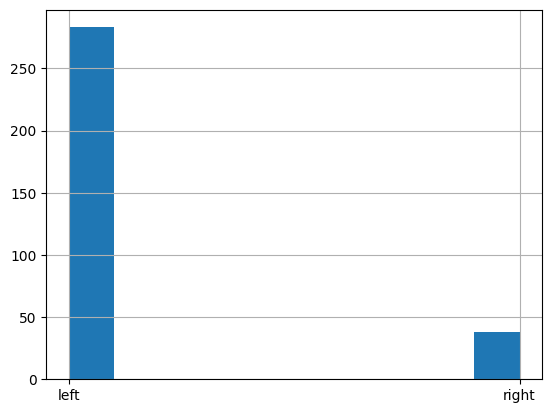

In [ ]:
politics_merged['ideology_binary'][politics_merged['tag']=='Alfaro_Ola1'].hist()

<Axes: >

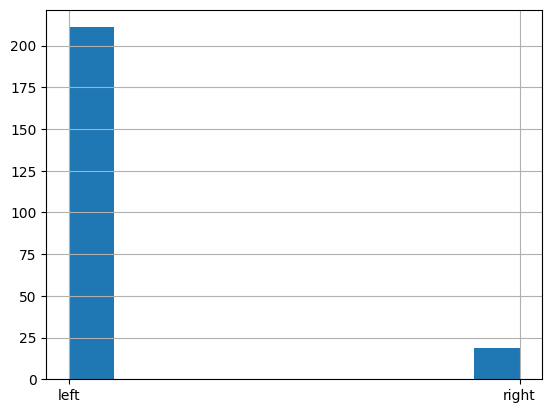

In [ ]:
politics_merged['ideology_binary'][politics_merged['tag']=='Alfaro_Ola2'].hist()

<Axes: >

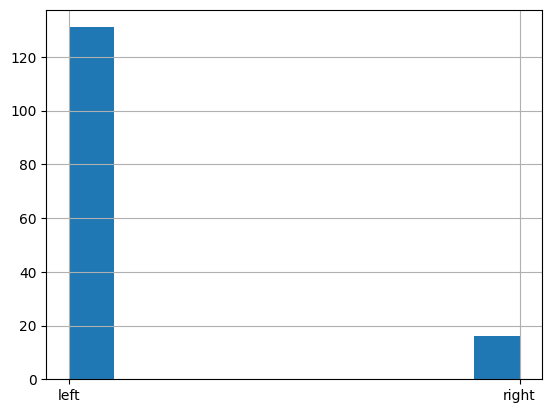

In [ ]:
politics_merged['ideology_binary'][politics_merged['tag']=='Alfaro_Ola3'].hist()

<Axes: >

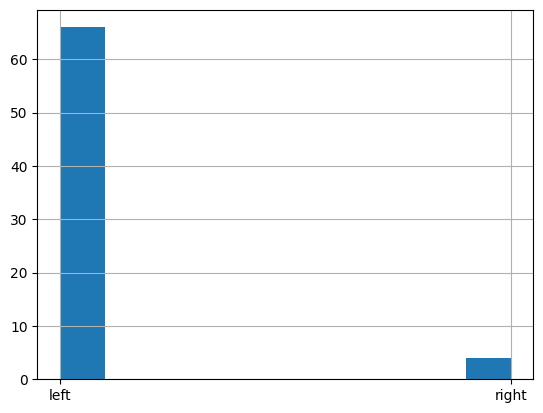

In [ ]:
politics_merged['ideology_binary'][politics_merged['tag']=='Alfredo_Ola1'].hist()

<Axes: >

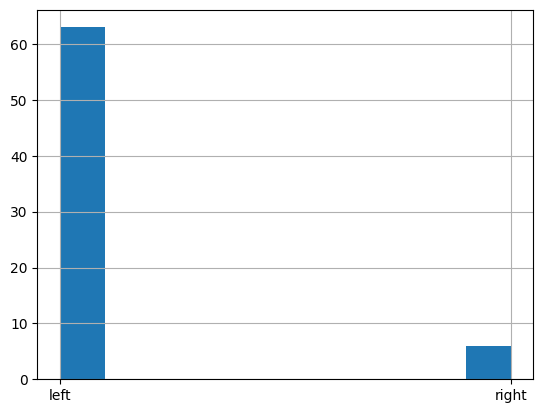

In [ ]:
politics_merged['ideology_binary'][politics_merged['tag']=='Alfredo_Ola2'].hist()

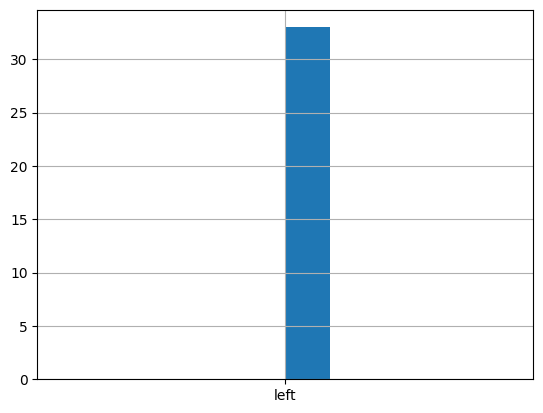

In [ ]:
politics_merged['ideology_binary'][politics_merged['tag']=='Alfredo_Ola3'].hist()

<Axes: >

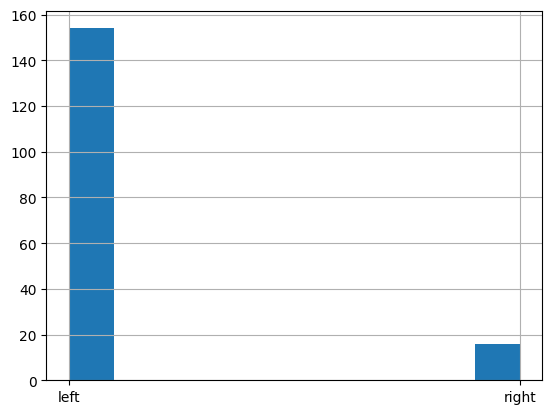

In [ ]:
politics_merged['ideology_binary'][politics_merged['tag']=='Sheibaum_Ola1'].hist()

<Axes: >

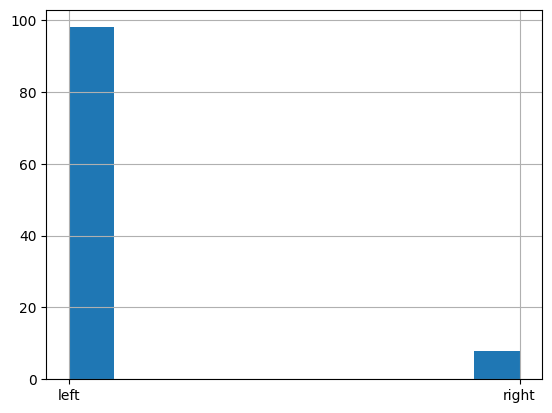

In [ ]:
politics_merged['ideology_binary'][politics_merged['tag']=='Sheibaum_Ola2'].hist()

<Axes: >

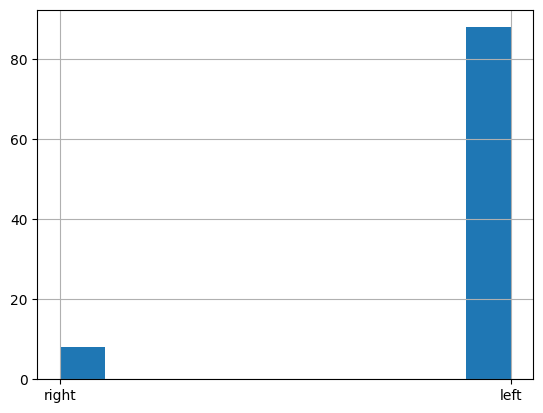

In [ ]:
politics_merged['ideology_binary'][politics_merged['tag']=='Sheibaum_Ola3'].hist()

<Axes: >

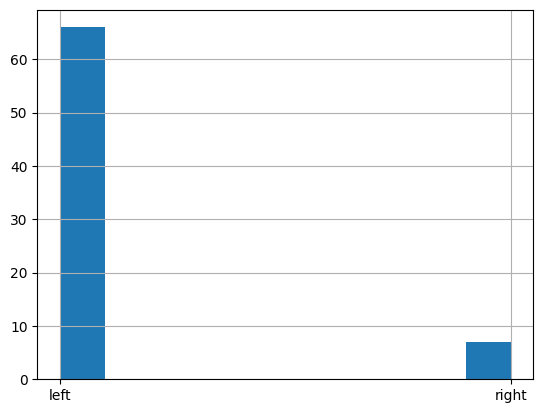

In [ ]:
politics_merged['ideology_binary'][politics_merged['tag']=='Cuitlahuac_Ola1'].hist()

<Axes: >

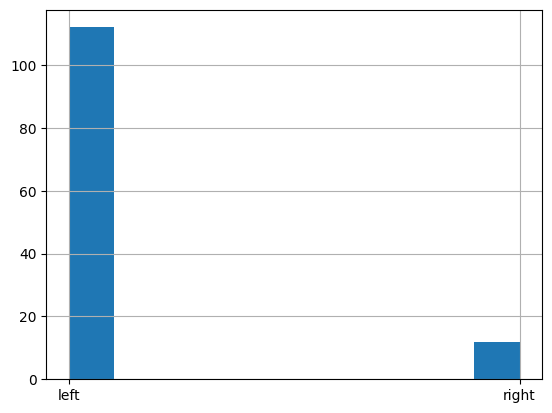

In [ ]:
politics_merged['ideology_binary'][politics_merged['tag']=='Cuitlahuac_Ola2'].hist()

<Axes: >

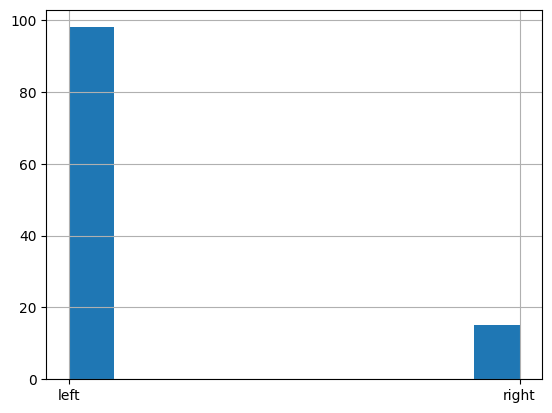

In [ ]:
politics_merged['ideology_binary'][politics_merged['tag']=='Cuitlahuac_Ola3'].hist()

<Axes: >

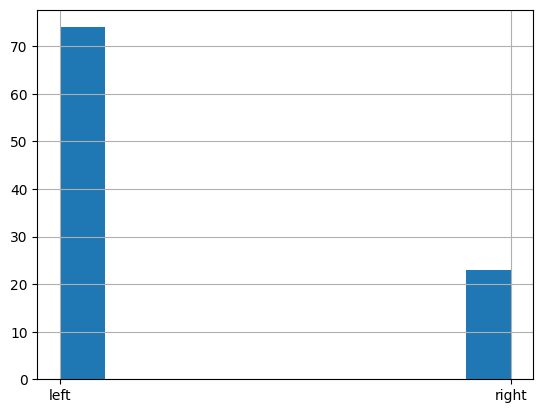

In [ ]:
politics_merged['ideology_binary'][politics_merged['tag']=='Sinhue_Ola1'].hist()

<Axes: >

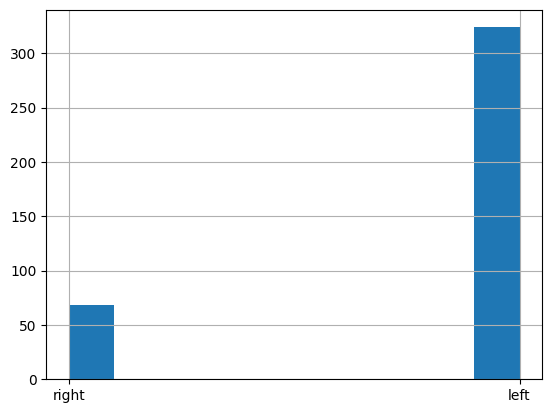

In [ ]:
politics_merged['ideology_binary'][politics_merged['tag']=='Sinhue_Ola2'].hist()

<Axes: >

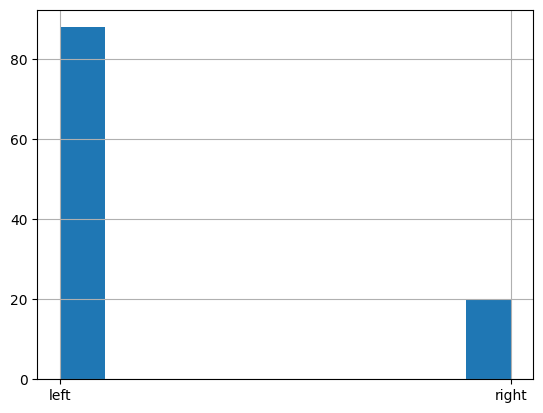

In [ ]:
politics_merged['ideology_binary'][politics_merged['tag']=='Sinhue_Ola3'].hist()

<Axes: >

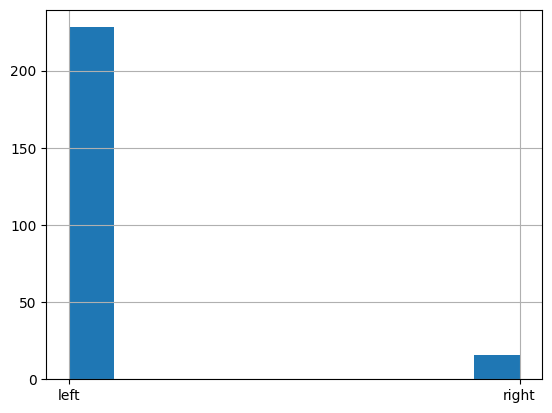

In [ ]:
politics_merged['ideology_binary'][politics_merged['tag']=='Gattel_Ola1'].hist()

<Axes: >

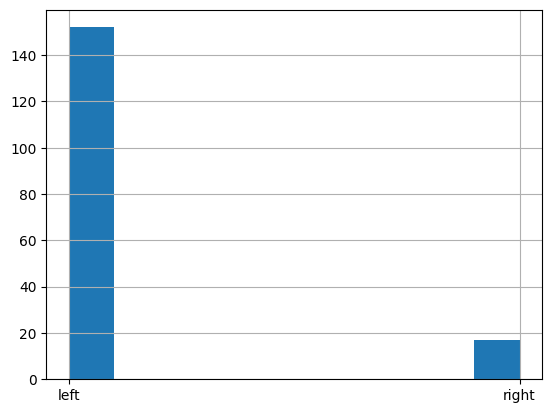

In [ ]:
politics_merged['ideology_binary'][politics_merged['tag']=='Gattel_Ola2'].hist()

<Axes: >

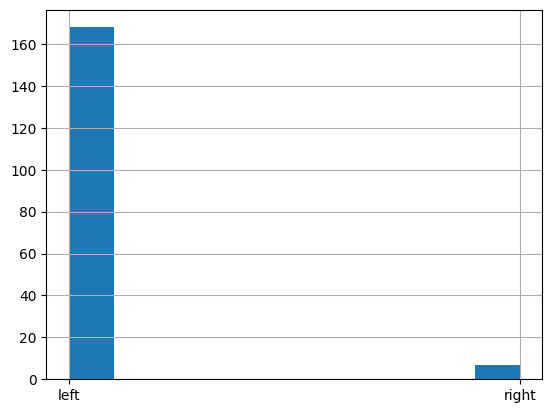

In [ ]:
politics_merged['ideology_binary'][politics_merged['tag']=='Gattel_Ola3'].hist()

<Axes: >

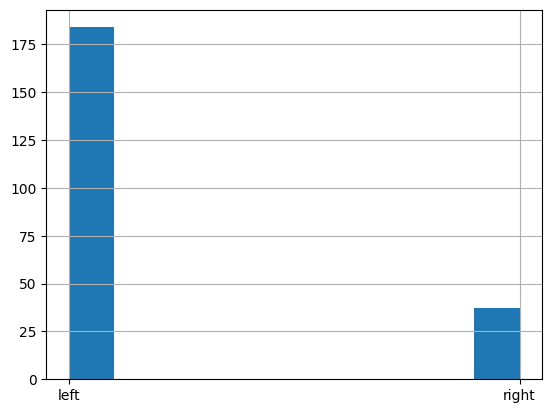

In [ ]:
politics_merged['ideology_binary'][politics_merged['tag']=='Jaime_Ola1'].hist()

<Axes: >

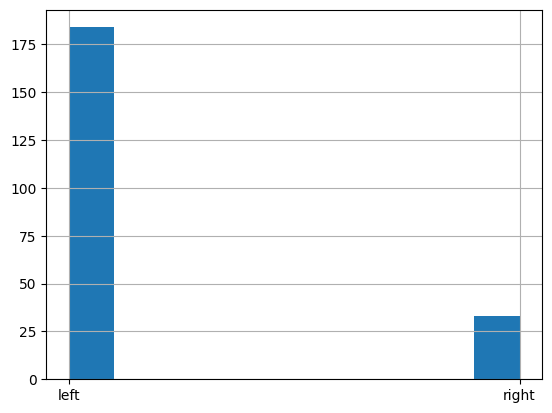

In [ ]:
politics_merged['ideology_binary'][politics_merged['tag']=='Jaime_Ola2'].hist()

<Axes: >

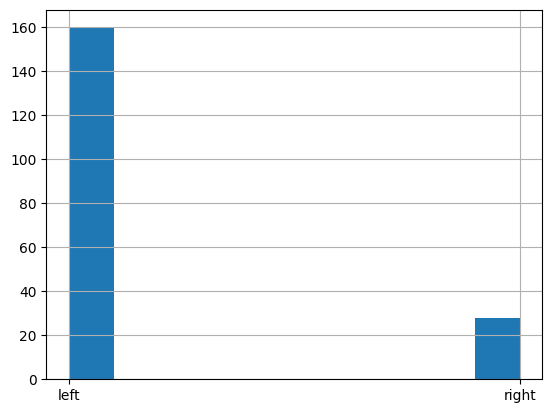

In [ ]:
politics_merged['ideology_binary'][politics_merged['tag']=='Jaime_Ola3'].hist()

<Axes: >

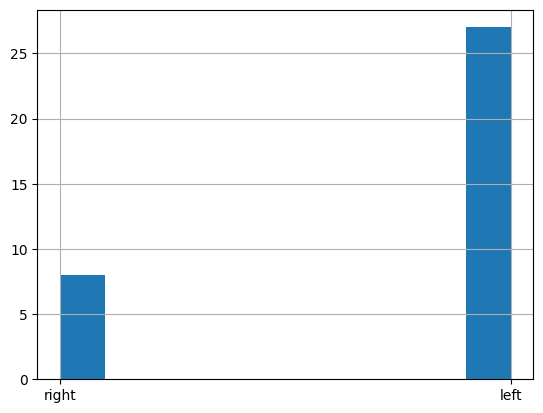

In [ ]:
politics_merged['ideology_binary'][politics_merged['tag']=='Amlo_Ola1'].hist()

<Axes: >

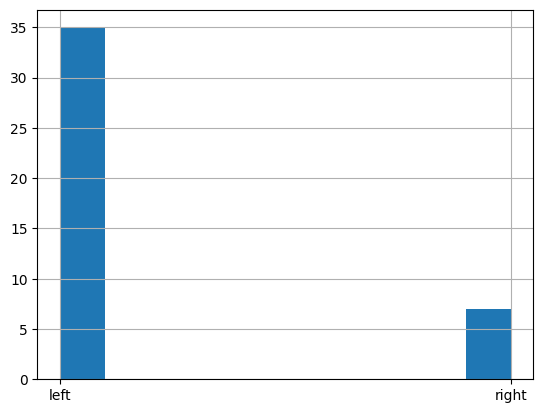

In [ ]:
politics_merged['ideology_binary'][politics_merged['tag']=='Amlo_Ola2'].hist()

<Axes: >

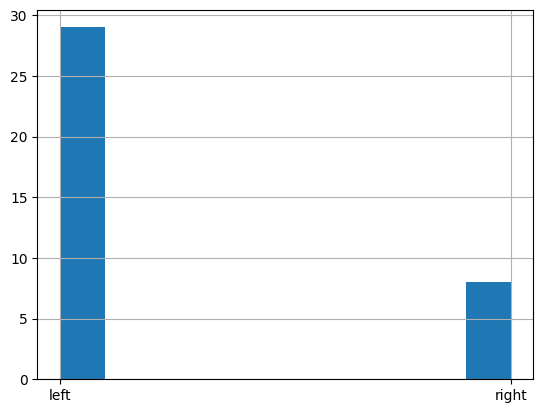

In [ ]:
politics_merged['ideology_binary'][politics_merged['tag']=='Amlo_Ola3'].hist()

<Axes: >

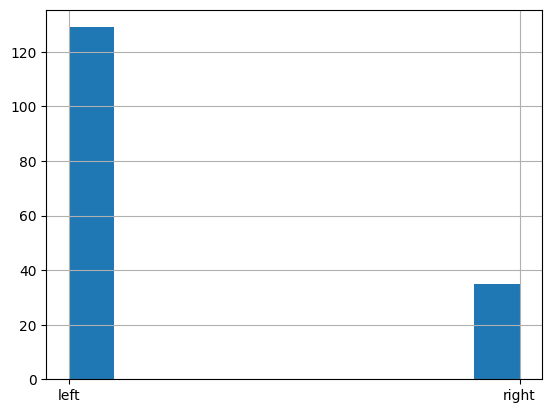

In [ ]:
politics_merged['ideology_binary'][politics_merged['tag']=='Barbosa_Ola1'].hist()

<Axes: >

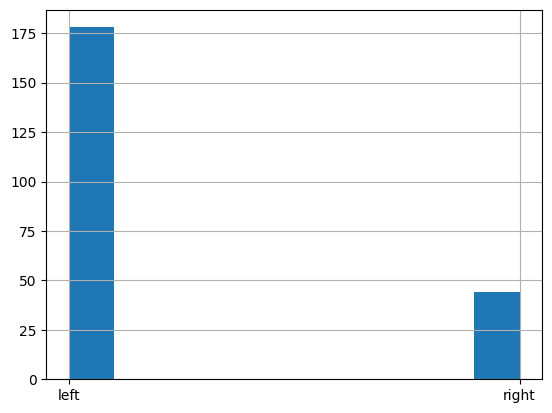

In [ ]:
politics_merged['ideology_binary'][politics_merged['tag']=='Barbosa_Ola2'].hist()

<Axes: >

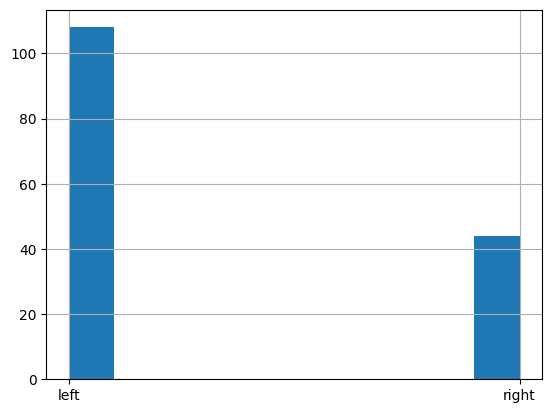

In [ ]:
politics_merged['ideology_binary'][politics_merged['tag']=='Barbosa_Ola3'].hist()

<Axes: >

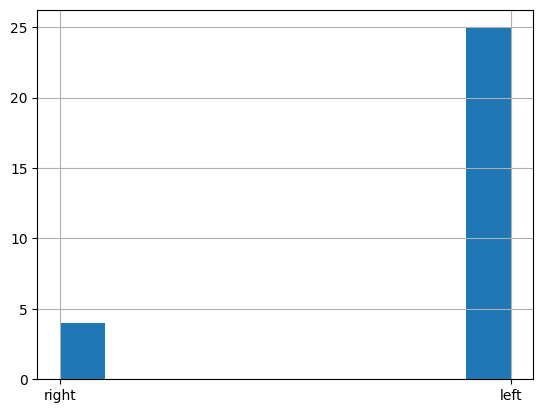

In [ ]:
politics_merged['ideology_binary'][politics_merged['tag']=='Alejandro_Ola1'].hist()

<Axes: >

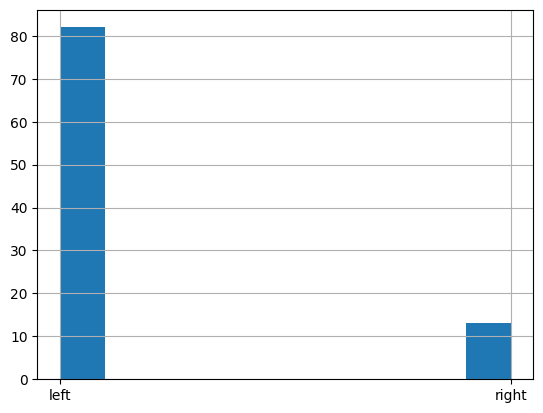

In [ ]:
politics_merged['ideology_binary'][politics_merged['tag']=='Alejandro_Ola2'].hist()

<Axes: >

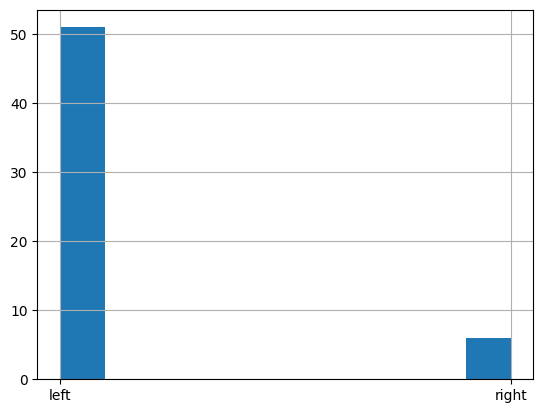

In [ ]:
politics_merged['ideology_binary'][politics_merged['tag']=='Alejandro_Ola3'].hist()

# d) Clasificador basado en LSTM

Comenzamos con la instalacion e importacion de librerias necesarias que son bastantes:


In [ ]:
!pip install -U torchtext
!pip install scikit-plot
#!pip install datasets
!pip install torchdata

In [ ]:
texts=list(train['tweet'])+list(test['tweet'])
#labels=np.array(train['ideology_binary'].map({'left': 0,  'right': 1}))
#labels=np.array(train['ideology_multiclass'].map({'left': 0, 'moderate_left':1, 'moderate_right': 2, 'right': 3}))

# Tokenize, build vocabulary, encode tokens
print("Tokenizing...\n")
tokenized_texts, word2idx, max_len = tokenize(texts)
input_ids = encode(tokenized_texts, word2idx, max_len)
#Longitud del vocabulario
print(len(word2idx))

import torch 
# Load pretrained vectors
embeddings = load_pretrained_vectors(word2idx, '/content/drive/MyDrive/embeddings-l-model.vec')
print(embeddings.shape)

embeddings = torch.tensor(embeddings)
embeddings = embeddings.to(device)

tr_y=list(train['ideology_binary'].map({'left': 0, 'right': 1}))

train_procesado=[]
for i in range(train.shape[0]):
  train_procesado.append( [ train['tweet'][i], tr_y[i] ] )

from sklearn.model_selection import train_test_split
train_procesado, val_procesado, y_train, y_val = train_test_split(train_procesado, tr_y, test_size=0.20, random_state=2022)

te_y=list(test['ideology_binary'].map({'left': 0, 'right': 1}))
test_procesado=[]
for i in range(test.shape[0]):
  test_procesado.append( [ test['tweet'][i], te_y[i] ] )


train_dataset = Dataset.from_pandas(train)
test_dataset = Dataset.from_pandas(test)

#Utilizamos los atributos de un objeto dataset, para construir mapeos
def tokenize_data(example,tokenizer):
  return  {'tokens': tokenizer(example['tweet'])} #, 'tokens1': tokenizer(example['V1']), 'tokens3': tokenizer(example['V3']), 'tokens4': tokenizer(example['V4']), 'tokens5': tokenizer(example['V5'])}

#Obtenemos los tokens para cada uno de los conjuntos 
tokenizer = get_tokenizer('basic_english')
tokenized_train_dataset = train_dataset.map(tokenize_data, remove_columns=['index', 'label', 'gender', 'profession', 'Longitud Char', 'V1', 'V3', 'V4', 'V5'], fn_kwargs={'tokenizer': tokenizer})
tokenized_test_dataset = test_dataset.map(tokenize_data, remove_columns=['index', 'label', 'gender', 'profession', 'V1', 'V3', 'V4', 'V5'], fn_kwargs={'tokenizer': tokenizer})

def build_vocab(dataset):
    tokens = dataset.map(tokenize_data,  fn_kwargs={'tokenizer': tokenizer})
    return tokens

#Se unen los conjuntos de tokens a traves de la instruccon concatenate de datasets
vocab = build_vocab_from_iterator(build_vocab(datasets.concatenate_datasets([train_dataset, test_dataset]))['tokens'], specials=["<UNK>", "<EOS>"], min_freq=2)
vocab.set_default_index(vocab["<UNK>"])
print('La longitud del vocabulario es ', len(vocab))

max_len=80
def vectorize_batch(batch):
    X,Y = list(zip(*batch))
    X = [vocab(tokenizer(sample)) for sample in X]
    X = [sample+([0]* (max_len-len(sample))) if len(sample)<max_len else sample[:max_len] for sample in X] 
    return torch.tensor(X, dtype=torch.int32).to(device), torch.tensor(Y).to(device) 

train_loader = DataLoader(train_procesado, batch_size=8, collate_fn=vectorize_batch)
val_loader=DataLoader(val_procesado, batch_size=8, collate_fn=vectorize_batch)
test_loader = DataLoader(test_procesado, batch_size=8, collate_fn=vectorize_batch)


In [ ]:
class LSTMClassifier(nn.Module):
    def __init__(self,
                 pretrained_embedding=None,
                 freeze_embedding=False,
                 vocab_size=None,
                 embed_dim=300,
                 hidden_dim=[100, 100, 100],
                 num_classes=2,
                 num_layers=1)
                 dropout=0.5):
        super(LSTMClassifier, self).__init__()
        # Embedding layer
        if pretrained_embedding is not None:
            self.vocab_size, self.embed_dim = pretrained_embedding.shape
            self.embedding = nn.Embedding.from_pretrained(pretrained_embedding,
                                                          freeze=freeze_embedding)
        else:
            self.embed_dim = embed_dim
            self.embedding = nn.Embedding(num_embeddings=vocab_size,
                                          embedding_dim=self.embed_dim,
                                          padding_idx=0,
                                          max_norm=5.0)
        
        # Conv Network
        self.hidden_dim=hidden_dim
        self.num_layers=num_layers
        self.num_classes=num_classes
        self.pretrained_embedding=pretrained_embedding
        self.lstm1 = nn.LSTM(input_size=embed_dim, hidden_size=hidden_dim[0], num_layers=num_layers, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=hidden_dim[0], hidden_size=hidden_dim[1], num_layers=num_layers, batch_first=True)
        #self.lstm3 = nn.LSTM(input_size=hidden_dim[1], hidden_size=hidden_dim[2], num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim[1],num_classes)

        self.dropout = nn.Dropout(p=dropout)

    def forward(self, X_batch):
        if self.pretrained_embedding is not None:
          embeddings = self.embedding(X_batch).float()
        else: 
          embeddings = self.embedding(X_batch)
  
        embeddings = embeddings.to(device)
        hidden, carry = torch.randn(self.num_layers, len(X_batch), self.hidden_dim[0]), torch.randn(self.num_layers, len(X_batch), self.hidden_dim[0])
        output, (hidden, carry) = self.lstm1(embeddings, (hidden.to(device), carry.to(device)))

        hidden, carry = torch.randn(self.num_layers, len(X_batch), self.hidden_dim[1]), torch.randn(self.num_layers, len(X_batch), self.hidden_dim[1])
        output, (hidden, carry) = self.lstm2(output, (hidden.to(device), carry.to(device)))

       # hidden, carry = torch.randn(self.num_layers, len(X_batch), self.hidden_dim[2]), torch.randn(self.num_layers, len(X_batch), self.hidden_dim[2])
        #output, (hidden, carry) = self.lstm3(output, (hidden.to(device), carry.to(device)))

        return self.linear(output[:,-1])

from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import accuracy_score, f1_score
import gc

def CalcValLossAndAccuracy(model, loss_fn, val_loader):
    with torch.no_grad():
        Y_shuffled, Y_preds, losses = [],[],[]
        for X, Y in tqdm(val_loader):
            X = X.to(device)
            Y = Y.to(device)
            preds = model(X)
            loss = loss_fn(preds, Y)
            losses.append(loss.item())

            Y_shuffled.append(Y)
            Y_preds.append(preds.argmax(dim=-1))

        Y_shuffled = torch.cat(Y_shuffled)
        Y_preds = torch.cat(Y_preds)

        print("Valid Loss : {:.3f}".format(torch.tensor(losses).mean()))
        print("Valid acc : {:.3f}".format(accuracy_score(Y_shuffled.detach().cpu().numpy(), Y_preds.detach().cpu().numpy())))


def TrainModel(model, loss_fn, optimizer, train_loader, val_loader, epochs=10):
    for i in range(1, epochs+1):
        losses = []
        for X, Y in tqdm(train_loader):
            X = X.to(device)
            Y = Y.to(device)
            Y_preds = model(X)

            loss = loss_fn(Y_preds, Y)
            losses.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print("Train Loss : {:.3f}".format(torch.tensor(losses).mean()))
        CalcValLossAndAccuracy(model, loss_fn, val_loader)

def MakePredictions(model, loader):
    Y_shuffled, Y_preds = [], []
    for X, Y in loader:
        X = X.to(device)
        Y = Y.to(device)
        preds = model(X)
        Y_preds.append(preds)
        Y_shuffled.append(Y)
    gc.collect()
    Y_preds, Y_shuffled = torch.cat(Y_preds), torch.cat(Y_shuffled)

    return Y_shuffled.detach().cpu().numpy(), torch.nn.functional.softmax(Y_preds, dim=-1).argmax(dim=-1).detach().cpu().numpy()


##Entrenamiento 

###Original


####Binario

In [ ]:
from torch.optim import Adam, SGD
epochs = 5
learning_rate = 0.01

loss_fn = nn.CrossEntropyLoss()
lstm_classifier = LSTMClassifier(vocab_size=len(vocab), pretrained_embedding=embeddings ,hidden_dim=[500,500,500], dropout=0.5, freeze_embedding=False, num_classes=2)
lstm_classifier.to(device)
optimizer = Adam(lstm_classifier.parameters(), lr=learning_rate)

TrainModel(lstm_classifier, loss_fn, optimizer, train_loader, val_loader, epochs)

In [ ]:
# Garbage Collector - use it like gc.collect()
import gc
gc.collect()
Y_actual, Y_preds = MakePredictions(lstm_classifier, test_loader)
classes= ['left', 'right']
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix

print("Test Accuracy : {}".format(f1_score(Y_actual, Y_preds, average='macro')))
print("\nClassification Report : ")
print(classification_report(Y_actual, Y_preds, target_names=classes))
print("\nConfusion Matrix : ")
print(confusion_matrix(Y_actual, Y_preds))

In [ ]:
from torch.optim import Adam, SGD
epochs = 5
learning_rate = 0.1

loss_fn = nn.CrossEntropyLoss()
lstm_classifier = LSTMClassifier(vocab_size=len(vocab), pretrained_embedding=embeddings ,hidden_dim=[500,500,500], dropout=0.5, freeze_embedding=False)
lstm_classifier.to(device)
optimizer = Adam(lstm_classifier.parameters(), lr=learning_rate)

TrainModel(lstm_classifier, loss_fn, optimizer, train_loader, val_loader, epochs)

In [ ]:
# Garbage Collector - use it like gc.collect()
import gc
gc.collect()
Y_actual, Y_preds = MakePredictions(lstm_classifier, test_loader)
classes= ['left', 'right']
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix

print("Test Accuracy : {}".format(f1_score(Y_actual, Y_preds, average='macro')))
print("\nClassification Report : ")
print(classification_report(Y_actual, Y_preds, target_names=classes))
print("\nConfusion Matrix : ")
print(confusion_matrix(Y_actual, Y_preds))

#### Multiclase

In [ ]:
tr_y=np.array(train['ideology_multiclass'].map({'left': 0, 'moderate_left':1, 'moderate_right': 2, 'right': 3}))

train_procesado=[]
for i in range(train.shape[0]):
  train_procesado.append( [ train['tweet'][i], tr_y[i] ] )

from sklearn.model_selection import train_test_split
train_procesado, val_procesado, y_train, y_val = train_test_split(train_procesado, tr_y, test_size=0.20, random_state=2022)

te_y=np.array(test['ideology_multiclass'].map({'left': 0, 'moderate_left':1, 'moderate_right': 2, 'right': 3}))
test_procesado=[]
for i in range(test.shape[0]):
  test_procesado.append( [ test['tweet'][i], te_y[i] ] )

train_dataset = Dataset.from_pandas(train)
test_dataset = Dataset.from_pandas(test)

#Utilizamos los atributos de un objeto dataset, para construir mapeos
def tokenize_data(example,tokenizer):
  return  {'tokens': tokenizer(example['tweet'])} #, 'tokens1': tokenizer(example['V1']), 'tokens3': tokenizer(example['V3']), 'tokens4': tokenizer(example['V4']), 'tokens5': tokenizer(example['V5'])}

#Obtenemos los tokens para cada uno de los conjuntos 
tokenizer = get_tokenizer('basic_english')
tokenized_train_dataset = train_dataset.map(tokenize_data, remove_columns=['index', 'label', 'gender', 'profession', 'Longitud Char', 'V1', 'V3', 'V4', 'V5'], fn_kwargs={'tokenizer': tokenizer})
tokenized_test_dataset = test_dataset.map(tokenize_data, remove_columns=['index', 'label', 'gender', 'profession', 'V1', 'V3', 'V4', 'V5'], fn_kwargs={'tokenizer': tokenizer})

def build_vocab(dataset):
    tokens = dataset.map(tokenize_data,  fn_kwargs={'tokenizer': tokenizer})
    return tokens

#Se unen los conjuntos de tokens a traves de la instruccon concatenate de datasets
vocab = build_vocab_from_iterator(build_vocab(datasets.concatenate_datasets([train_dataset, test_dataset]))['tokens'], specials=["<UNK>", "<EOS>"], min_freq=2)
vocab.set_default_index(vocab["<UNK>"])
print('La longitud del vocabulario es ', len(vocab))

max_len=80
def vectorize_batch(batch):
    X,Y = list(zip(*batch))
    X = [vocab(tokenizer(sample)) for sample in X]
    X = [sample+([0]* (max_len-len(sample))) if len(sample)<max_len else sample[:max_len] for sample in X] 
    return torch.tensor(X, dtype=torch.int32).to(device), torch.tensor(Y).to(device) 

train_loader = DataLoader(train_procesado, batch_size=8, collate_fn=vectorize_batch)
val_loader=DataLoader(val_procesado, batch_size=8, collate_fn=vectorize_batch)
test_loader = DataLoader(test_procesado, batch_size=8, collate_fn=vectorize_batch)

In [ ]:
from torch.optim import Adam, SGD
epochs = 5
learning_rate = 0.01

loss_fn = nn.CrossEntropyLoss()
lstm_classifier = LSTMClassifier(vocab_size=len(vocab), pretrained_embedding=embeddings ,hidden_dim=[500,500,500], dropout=0.5, freeze_embedding=False, num_classes=4)
lstm_classifier.to(device)
optimizer = Adam(lstm_classifier.parameters(), lr=learning_rate)

TrainModel(lstm_classifier, loss_fn, optimizer, train_loader, val_loader, epochs)



In [ ]:
# Garbage Collector - use it like gc.collect()
import gc
gc.collect()
Y_actual, Y_preds = MakePredictions(lstm_classifier, test_loader)
classes= ['left', 'right']
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Test Accuracy : {}".format(accuracy_score(Y_actual, Y_preds)))
print("\nClassification Report : ")
print(classification_report(Y_actual, Y_preds, target_names=classes))
print("\nConfusion Matrix : ")
print(confusion_matrix(Y_actual, Y_preds))

In [ ]:
from torch.optim import Adam, SGD
epochs = 5
learning_rate = 0.1

loss_fn = nn.CrossEntropyLoss()
lstm_classifier = LSTMClassifier(vocab_size=len(vocab), pretrained_embedding=embeddings ,hidden_dim=[500,500,500], dropout=0.5, freeze_embedding=False,  num_classes=4)
lstm_classifier.to(device)
optimizer = Adam(lstm_classifier.parameters(), lr=learning_rate)

TrainModel(lstm_classifier, loss_fn, optimizer, train_loader, val_loader, epochs)

In [ ]:
# Garbage Collector - use it like gc.collect()
import gc
gc.collect()
Y_actual, Y_preds = MakePredictions(lstm_classifier, test_loader)
classes= ['left', 'right']
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Test Accuracy : {}".format(accuracy_score(Y_actual, Y_preds)))
print("\nClassification Report : ")
print(classification_report(Y_actual, Y_preds, target_names=classes))
print("\nConfusion Matrix : ")
print(confusion_matrix(Y_actual, Y_preds))